In [480]:
from io import StringIO
import pandas as pd
import statsmodels.api as sm
import numpy as np
import warnings
import re
import matplotlib.pyplot as plt

In [481]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from datetime import datetime
import pandas as pd
from bs4 import BeautifulSoup
import requests

driver = webdriver.Chrome(service=ChromeService())

driver.get('https://www.spglobal.com/en/press/press-release#q=Set%20to%20join&rows=1000&pagenum=1&sort=es_unified_dt%20desc')

# Wait for the cards with aria-label to load
wait = WebDriverWait(driver, 15)
cards = wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, '[aria-label="search results card"]')))

print(f"Found {len(cards)} result cards:\n")
texts = []
links = []
for card in cards:
    try:
        # Get link inside the card
        link_element = card.find_element(By.TAG_NAME, 'a')
        href = link_element.get_attribute('href')

        # Get the text of the entire card (title, date, etc.)
        text = card.text.strip()
        texts.append(text)
        links.append(href)
        # print(f"Link: {href}")
        # print(f"Text:\n{text}")
        # print("=" * 50)

    except Exception as e:
        print(f"Could not extract data from card: {e}")

driver.quit()


The chromedriver version (136.0.7103.113) detected in PATH at /usr/local/bin/chromedriver might not be compatible with the detected chrome version (137.0.7151.55); currently, chromedriver 137.0.7151.55 is recommended for chrome 137.*, so it is advised to delete the driver in PATH and retry


Found 629 result cards:



In [482]:
date_link = {}
for i in range(len(texts)):
    date_link[i] = {
        'link': links[i],
        'date': texts[i].split("\n")[1]
    }

In [594]:
# def format_date(day):
#     print(day)
#     if pd.isna(day):
#         return None
#     return datetime.strptime(day.replace(' ', ''), "%b%d,%Y").strftime("%m/%d/%Y")
def format_date(day):
    if pd.isna(day):
        return None
    day_clean = day.replace(' ', '')
    day_clean = day.replace('/', '')
    for fmt in ("%b%d,%Y", "%B%d,%Y"):
        try:
            return datetime.strptime(day_clean, fmt).strftime("%m/%d/%Y")
        except ValueError:
            return day


def format_add_del(s):
    def map_value(val):
        if val == 'Addition' or val == 'ADDED':
            return 'Add'
        elif val == 'Deletion' or val == 'DELETED':
            return 'Del'
        return val  # fallback

    if isinstance(s, pd.Series):
        return s.apply(map_value)
    else:
        return map_value(s)


def get_info(date, link):
    response = requests.get(link)
    soup = BeautifulSoup(response.content, 'html.parser')
    merger = False
    # df = pd.read_html(str(soup.table))[0]
    if 'acquiring' in response.text:
        print(link)
        merger = True
    if soup.table:
        df = pd.read_html(StringIO(str(soup.table)), flavor='lxml')[0]
        df.columns = df.iloc[0]
        df = df[1:].reset_index(drop=True)
        df = df.rename(columns={'Effective Date': 'Trade Date',
                    'GICS Sector': 'Sector', 'Index Name': 'Index Change'})
        df['Action'] = df['Action'].apply(format_add_del)
        df['Announced'] = format_date(date)
        df['Trade Date'] = df['Trade Date'].apply(format_date)
        df['Merger'] = merger
        df = df.loc[:, ~df.columns.duplicated(keep='first')]
        return df
    else:
        return pd.DataFrame()
    # except:
    #     return pd.DataFrame()



def main(lst):
    df = pd.DataFrame()
    for i in lst:
        link = lst[i]['link']
        date = lst[i]['date']
        if date == 'Jul 20, 2020':
            break
        if 'set-to-join' in link.lower():
            new_df = get_info(date, link).reset_index(drop=True)
            df = pd.concat([df, new_df], ignore_index=True)
    return df

In [484]:
len(date_link)

629

In [485]:
csv = main(date_link)

https://press.spglobal.com/2025-05-19-Pegasystems-Set-to-Join-S-P-MidCap-400
https://press.spglobal.com/2025-05-12-Coinbase-Global-Set-to-Join-S-P-500
https://press.spglobal.com/2025-04-28-Okta-Set-to-Join-S-P-MidCap-400
https://press.spglobal.com/2025-04-14-Sterling-Infrastructure-Set-to-Join-S-P-SmallCap-600
https://press.spglobal.com/2025-04-09-Enact-Holdings-Set-to-Join-S-P-SmallCap-600
https://press.spglobal.com/2025-03-04-Albertsons-Companies-Set-to-Join-S-P-MidCap-400
https://press.spglobal.com/2025-02-27-Entegris-Set-to-Join-S-P-MidCap-400
https://press.spglobal.com/2025-02-13-Kadant-Set-to-Join-S-P-SmallCap-600
https://press.spglobal.com/2025-02-10-Acushnet-Holdings-Set-to-Join-S-P-SmallCap-600
https://press.spglobal.com/2025-01-22-Guidewire-Software-Set-to-Join-S-P-MidCap-400-Arrowhead-Pharmaceuticals-to-Join-S-P-SmallCap-600
https://press.spglobal.com/2025-01-07-Maplebear-Set-to-Join-S-P-MidCap-400-Enovis-to-Join-S-P-SmallCap-600
https://press.spglobal.com/2024-12-30-Acadia-

In [489]:
csv

,Trade Date,Index Change,Action,Company Name,Ticker,Sector,Announced,Merger,GICS Sector,GICS (Global Industry Classification Standard) Industry,GICS Sub-Industry
0,05/22/2025,S&P MidCap 400,Add,Pegasystems,PEGA,Information Technology,05/19/2025,True,NaN,NaN,NaN
1,05/22/2025,S&P MidCap 400,Del,Nordstrom,JWN,Consumer Discretionary,05/19/2025,True,NaN,NaN,NaN
2,05/19/2025,S&P 500,Add,Coinbase Global,COIN,Financials,05/12/2025,True,NaN,NaN,NaN
3,05/19/2025,S&P 500,Del,Discover Financial Services,DFS,Financials,05/12/2025,True,NaN,NaN,NaN
4,05/01/2025,S&P MidCap 400,Add,Okta,OKTA,Information Technology,04/28/2025,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1270,"August 3, 2020",S&P MidCap 400,Del,Carpenter Technology,CRS,Materials,07/28/2020,True,NaN,NaN,NaN
1271,"August 3, 2020",S&P SmallCap 600,Add,Deluxe Corp,DLX,Industrials,07/28/2020,True,NaN,NaN,NaN
1272,"August 3, 2020",S&P SmallCap 600,Del,El Paso Electric Co,EE,Utilities,07/28/2020,True,NaN,NaN,NaN
1273,"August 3, 2020",S&P SmallCap 600,Add,Carpenter Technology Corp,CRS,Materials,07/28/2020,True,NaN,NaN,NaN


In [86]:
csv.to_csv('events_1.csv')

In [10]:
csv.to_csv('event_data2.csv', index=False)

In [7]:
import os
os.getcwd()

'/Users/michael/Downloads'

In [82]:
for i in date_link:
    print(date_link[i]['date'])

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

In [80]:
html_code = []
for i in date_link:
    link = date_link[i]['link']
    response = requests.get(link)
    soup = BeautifulSoup(response.content, 'html.parser')
    html_code.append(soup.find('div', class_='wd_content'))

In [87]:
html_code[1]

<div class="wd_content">
<div id="wd_printable_content">
<div class="wd_newsfeed_releases-detail">
<div class="wd_title wd_language_left">Coinbase Global Set to Join S&amp;P 500</div>
<div class="wd_toolbar wd_toolbar-detail"><ul class="wd_tools"><li class="wd_tool wd_tool-print"><span class="wd_tool_icon"><a href="#print" onclick="view_printable(); return false;" rel="nofollow" title="print"><span class="fa fa-print"></span></a></span></li><li class="wd_tool wd_tool-socialshare_facebook"><span class="wd_tool_icon">
<a href="https://www.facebook.com/sharer/sharer.php?u=https%3A%2F%2Fpress.spglobal.com%2Findex.php%3Fs%3D2429%26item%3D136308" style="background-color:#4267B2;" target="_blank" title="Facebook Share">
<span class="fa fa-facebook"></span>
<span class="wd_sr-only wd_sr-only-focusable"></span>
</a>
</span></li><li class="wd_tool wd_tool-socialshare_linkedin"><span class="wd_tool_icon">
<a href="https://www.linkedin.com/shareArticle?mini=true&amp;url=https%3A%2F%2Fpress.spgloba

In [492]:
def extract_index_changes(url):
    # 1) Fetch & parse
    resp = requests.get(url)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")
    merger = False
    if 'acquiring' in resp.text:
        merger = True
    # 2) Announced date
    ann_tag = soup.find("span", class_="xn-chron")
    announced = ann_tag.get_text(strip=True) if ann_tag else "N/A"

    # 3) Full text (for ticker regex)
    page_text = soup.get_text()

    records = []
    # tables = soup.find_all("table", class_="prntblns")
    tables = soup.find_all("table")
    
    # print(tables)
    for table in tables:
        # Header row → Index name + Trade Date
        hdr = table.find("tr").get_text()
        m = re.search(r"(S&P.*?INDEX)\s+–\s+(.*)", hdr)
        index_name = m.group(1).strip() if m else "Unknown"
        trade_date = m.group(2).strip().upper() if m else "Unknown"

        # Data rows begin at the 3rd <tr>
        for row in table.find_all("tr")[2:]:
            cells = row.find_all("td")
            # Skip any row that doesn’t have at least 4 cells
            if len(cells) < 4:
                continue

            action  = cells[0].get_text(strip=True).upper()
            company = cells[1].get_text(strip=True)
            sector  = cells[2].get_text(strip=True)
            # sub_ind = cells[3].get_text(strip=True)  # if you need sub-industry

            # Find ticker right after the company name in the page text
            tm = re.search(
                rf"{re.escape(company)}.*?\((?:NYSE|NASD):\s*([A-Z]+)\)",
                page_text
            )
            ticker = tm.group(1) if tm else "N/A"

            records.append({
                "Trade Date":   trade_date,
                "Index":        index_name,
                "Change":       action,
                "Action":       action,
                "Company Name": company,
                "Ticker":       ticker,
                "Sector":       sector,
                "Announced":    announced,
                "URL": url,
                "Merger": merger
            })

    return pd.DataFrame(records)

# Example:
if __name__ == "__main__":
    url = "https://press.spglobal.com/2020-06-24-TopBuild-Set-to-Join-S-P-MidCap-400-Retail-Properties-of-America-and-Brandywine-Realty-Trust-to-Join-S-P-SmallCap-600"
    df = extract_index_changes(url)
    print(df)


      Trade Date                 Index   Change   Action  \
0  JUNE 30, 2020  S&P MIDCAP 400 INDEX    ADDED    ADDED   
1  JUNE 30, 2020  S&P MIDCAP 400 INDEX  DELETED  DELETED   
2  JUNE 30, 2020  S&P MIDCAP 400 INDEX                     
3  JUNE 30, 2020  S&P MIDCAP 400 INDEX    ADDED    ADDED   
4  JUNE 30, 2020  S&P MIDCAP 400 INDEX                     
5  JUNE 30, 2020  S&P MIDCAP 400 INDEX  DELETED  DELETED   
6  JUNE 30, 2020  S&P MIDCAP 400 INDEX                     

                   Company Name Ticker                  Sector      Announced  \
0                      TopBuild    BLD  Consumer Discretionary  June 24, 2020   
1                     Tech Data   TECD  Information Technology  June 24, 2020   
2                       COMPANY    N/A    GICS ECONOMIC SECTOR  June 24, 2020   
3  Retail Properties of America   RPAI             Real Estate  June 24, 2020   
4       Brandywine Realty Trust    BDN             Real Estate  June 24, 2020   
5                      TopBuild  

In [493]:
extract_index_changes('https://press.spglobal.com/2012-07-25-SolarWinds-Inc-to-Join-S-P-MidCap-400-HealthStream-Inc-to-Join-the-S-P-SmallCap-600')

,Trade Date,Index,Change,Action,Company Name,Ticker,Sector,Announced,URL,Merger
0,"JULY 31, 2012",S&P MIDCAP 400 INDEX,ADDED,ADDED,SolarWinds,SWI,Information Technology,"July 25, 2012",https://press.spglobal.com/2012-07-25-SolarWin...,True
1,"JULY 31, 2012",S&P MIDCAP 400 INDEX,DELETED,DELETED,Gen-Probe,GPRO,Health Care,"July 25, 2012",https://press.spglobal.com/2012-07-25-SolarWin...,True
2,"JULY 31, 2012",S&P SMALLCAP 600 INDEX,ADDED,ADDED,HealthStream,HSTM,Health Care,"July 25, 2012",https://press.spglobal.com/2012-07-25-SolarWin...,True
3,"JULY 31, 2012",S&P SMALLCAP 600 INDEX,DELETED,DELETED,GeoResources,GEOI,Energy,"July 25, 2012",https://press.spglobal.com/2012-07-25-SolarWin...,True


In [494]:
keep_storing = False
all_df = pd.DataFrame()
for i in date_link:
    if date_link[i]['date'] == 'Jul 20, 2020':
        keep_storing = True
    if keep_storing:
        url = date_link[i]['link']
        if 'join' in url.lower():
            new_df = extract_index_changes(url).reset_index(drop=True)
            all_df = pd.concat([all_df, new_df], ignore_index=True)

In [495]:
renamed_df = all_df.rename(columns={'Index': 'Index Change'})

In [497]:
csv

,Trade Date,Index Change,Action,Company Name,Ticker,Sector,Announced,Merger,GICS Sector,GICS (Global Industry Classification Standard) Industry,GICS Sub-Industry
0,05/22/2025,S&P MidCap 400,Add,Pegasystems,PEGA,Information Technology,05/19/2025,True,NaN,NaN,NaN
1,05/22/2025,S&P MidCap 400,Del,Nordstrom,JWN,Consumer Discretionary,05/19/2025,True,NaN,NaN,NaN
2,05/19/2025,S&P 500,Add,Coinbase Global,COIN,Financials,05/12/2025,True,NaN,NaN,NaN
3,05/19/2025,S&P 500,Del,Discover Financial Services,DFS,Financials,05/12/2025,True,NaN,NaN,NaN
4,05/01/2025,S&P MidCap 400,Add,Okta,OKTA,Information Technology,04/28/2025,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1270,"August 3, 2020",S&P MidCap 400,Del,Carpenter Technology,CRS,Materials,07/28/2020,True,NaN,NaN,NaN
1271,"August 3, 2020",S&P SmallCap 600,Add,Deluxe Corp,DLX,Industrials,07/28/2020,True,NaN,NaN,NaN
1272,"August 3, 2020",S&P SmallCap 600,Del,El Paso Electric Co,EE,Utilities,07/28/2020,True,NaN,NaN,NaN
1273,"August 3, 2020",S&P SmallCap 600,Add,Carpenter Technology Corp,CRS,Materials,07/28/2020,True,NaN,NaN,NaN


In [496]:
renamed_df

,Trade Date,Index Change,Change,Action,Company Name,Ticker,Sector,Announced,URL,Merger
0,"JULY 24, 2020",S&P MIDCAP 400 INDEX,ADDED,ADDED,Emergent Biosolutions,N/A,Health Care,"July 20, 2020",https://press.spglobal.com/2020-07-20-Emergent...,False
1,"JULY 24, 2020",S&P MIDCAP 400 INDEX,DELETED,DELETED,Caesars Entertainment,CZR,Consumer Discretionary,"July 20, 2020",https://press.spglobal.com/2020-07-20-Emergent...,False
2,"JULY 24, 2020",S&P SMALLCAP 600 INDEX,ADDED,ADDED,First Hawaiian,FHB,Financials,"July 20, 2020",https://press.spglobal.com/2020-07-20-Emergent...,False
3,"JULY 24, 2020",S&P SMALLCAP 600 INDEX,DELETED,DELETED,Emergent Biosolutions,N/A,Health Care,"July 20, 2020",https://press.spglobal.com/2020-07-20-Emergent...,False
4,"JULY 1, 2020",S&P SMALLCAP 600 INDEX,ADDED,ADDED,SITE Centers,SITC,Real Estate,"June 25, 2020",https://press.spglobal.com/2020-06-25-SITE-Cen...,True
...,...,...,...,...,...,...,...,...,...,...
2181,"JULY 30, 2012",S&P 500 INDEX,DELETED,DELETED,Goodrich,GR,Industrials,"July 26, 2012",https://press.spglobal.com/2012-07-26-Ensco-pl...,True
2182,"JULY 31, 2012",S&P MIDCAP 400 INDEX,ADDED,ADDED,SolarWinds,SWI,Information Technology,"July 25, 2012",https://press.spglobal.com/2012-07-25-SolarWin...,True
2183,"JULY 31, 2012",S&P MIDCAP 400 INDEX,DELETED,DELETED,Gen-Probe,GPRO,Health Care,"July 25, 2012",https://press.spglobal.com/2012-07-25-SolarWin...,True
2184,"JULY 31, 2012",S&P SMALLCAP 600 INDEX,ADDED,ADDED,HealthStream,HSTM,Health Care,"July 25, 2012",https://press.spglobal.com/2012-07-25-SolarWin...,True


In [499]:
tmp = pd.read_csv('tmp_events2.csv')

In [661]:
ll = ll.rename({'Index Change': 'Index', 'Company Name' : 'Company', 'Trade Date' : 'Date'}, axis=1)
ll

,Date,Index,Action,Company,Ticker,Sector,Announced,Merger,GICS Sector,GICS (Global Industry Classification Standard) Industry,GICS Sub-Industry,Change,URL,Annouced,Announced Date
0,05/22/2025,S&P MidCap 400,Add,Pegasystems,PEGA,Information Technology,05/19/2025,True,NaN,NaN,NaN,NaN,NaN,20250519,20250519
1,05/22/2025,S&P MidCap 400,Del,Nordstrom,JWN,Consumer Discretionary,05/19/2025,True,NaN,NaN,NaN,NaN,NaN,20250519,20250519
2,05/19/2025,S&P 500,Add,Coinbase Global,COIN,Financials,05/12/2025,True,NaN,NaN,NaN,NaN,NaN,20250512,20250512
3,05/19/2025,S&P 500,Del,Discover Financial Services,DFS,Financials,05/12/2025,True,NaN,NaN,NaN,NaN,NaN,20250512,20250512
4,05/01/2025,S&P MidCap 400,Add,Okta,OKTA,Information Technology,04/28/2025,True,NaN,NaN,NaN,NaN,NaN,20250428,20250428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3456,"JULY 30, 2012",S&P 500 INDEX,Del,Goodrich,GR,Industrials,"Jul 26, 2012",True,NaN,NaN,NaN,DELETED,https://press.spglobal.com/2012-07-26-Ensco-pl...,20120726,20120726
3457,"JULY 31, 2012",S&P MIDCAP 400 INDEX,Add,SolarWinds,SWI,Information Technology,"Jul 25, 2012",True,NaN,NaN,NaN,ADDED,https://press.spglobal.com/2012-07-25-SolarWin...,20120725,20120725
3458,"JULY 31, 2012",S&P MIDCAP 400 INDEX,Del,Gen-Probe,GPRO,Health Care,"Jul 25, 2012",True,NaN,NaN,NaN,DELETED,https://press.spglobal.com/2012-07-25-SolarWin...,20120725,20120725
3459,"JULY 31, 2012",S&P SMALLCAP 600 INDEX,Add,HealthStream,HSTM,Health Care,"Jul 25, 2012",True,NaN,NaN,NaN,ADDED,https://press.spglobal.com/2012-07-25-SolarWin...,20120725,20120725


In [633]:
renamed_df['Announced'] = renamed_df['URL'].map(url_date_map)

In [634]:
ll = pd.concat([csv, renamed_df], ignore_index=True)

In [514]:
tmp

,Date,Index,Action,Company,Ticker,Sector,URL,Announced Date
0,20250522,S&P MidCap 400,Add,Pegasystems,PEGA,Information Technology,https://press.spglobal.com/2025-05-19-Pegasyst...,20250519
1,20250522,S&P MidCap 400,Del,Nordstrom,JWN,Consumer Discretionary,https://press.spglobal.com/2025-05-19-Pegasyst...,20250519
2,20250519,S&P 500,Add,Coinbase Global,COIN,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,20250512
3,20250519,S&P 500,Del,Discover Financial Services,DFS,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,20250512
4,20250501,S&P MidCap 400,Add,Okta,OKTA,Information Technology,https://press.spglobal.com/2025-04-28-Okta-Set...,20250428
...,...,...,...,...,...,...,...,...
3445,20120730,S&P 500 INDEX,Del,Goodrich,GR,Industrials,https://press.spglobal.com/2012-07-26-Ensco-pl...,20120726
3446,20120731,S&P MIDCAP 400 INDEX,Add,SolarWinds,SWI,Information Technology,https://press.spglobal.com/2012-07-25-SolarWin...,20120725
3447,20120731,S&P MIDCAP 400 INDEX,Del,Gen-Probe,GPRO,Health Care,https://press.spglobal.com/2012-07-25-SolarWin...,20120725
3448,20120731,S&P SMALLCAP 600 INDEX,Add,HealthStream,HSTM,Health Care,https://press.spglobal.com/2012-07-25-SolarWin...,20120725


In [628]:
url_date_map = {date_link[v]['link']: date_link[v]['date'] for v in date_link}


In [639]:
ll['Announced'].apply(form)

AttributeError: 'str' object has no attribute 'str'

In [640]:
ll['Action'] = ll['Action'].apply(format_add_del)
ll['Announced Date']

KeyError: 'Announced Date'

In [590]:
def form(date):
    try:
        month, day, year = date.split('/')
        return year + month + day
    except:
        return date


In [649]:
def form(series):
    def parse_date(x):
        x = str(x).strip()
        for fmt in ("%m/%d/%Y", "%b %d, %Y"):
            try:
                return datetime.strptime(x, fmt).strftime("%Y%m%d")
            except ValueError:
                continue
        return x  # return original if no format matches
    return series.apply(parse_date)

In [645]:
date_link

{0: {'link': 'https://press.spglobal.com/2025-05-19-Pegasystems-Set-to-Join-S-P-MidCap-400',
  'date': 'May 19, 2025'},
 1: {'link': 'https://press.spglobal.com/2025-05-12-Coinbase-Global-Set-to-Join-S-P-500',
  'date': 'May 12, 2025'},
 2: {'link': 'https://press.spglobal.com/2025-04-28-Okta-Set-to-Join-S-P-MidCap-400',
  'date': 'Apr 28, 2025'},
 3: {'link': 'https://press.spglobal.com/2025-04-14-Sterling-Infrastructure-Set-to-Join-S-P-SmallCap-600',
  'date': 'Apr 14, 2025'},
 4: {'link': 'https://press.spglobal.com/2025-04-09-Enact-Holdings-Set-to-Join-S-P-SmallCap-600',
  'date': 'Apr 09, 2025'},
 5: {'link': 'https://press.spglobal.com/2025-03-26-Cava-Group-Set-to-Join-S-P-MidCap-400-and-Angi-to-Join-S-P-SmallCap-600',
  'date': 'Mar 26, 2025'},
 6: {'link': 'https://press.spglobal.com/2025-03-07-DoorDash,-TKO-Group-Holdings,-Williams-Sonoma-and-Expand-Energy-Set-to-Join-S-P-500-Others-to-Join-S-P-100,-S-P-MidCap-400-and-S-P-SmallCap-600',
  'date': 'Mar 07, 2025'},
 7: {'link': 

In [664]:
ll['Annouced'] = form(ll['Announced'])
ll['Announced Date'] = form(ll['Announced'])
ll['Announced Date'] = ll['Announced Date'].astype(int)

In [656]:
tmp

,Date,Index,Action,Company,Ticker,Sector,URL,Announced Date
0,20250522,S&P MidCap 400,Add,Pegasystems,PEGA,Information Technology,https://press.spglobal.com/2025-05-19-Pegasyst...,20250519
1,20250522,S&P MidCap 400,Del,Nordstrom,JWN,Consumer Discretionary,https://press.spglobal.com/2025-05-19-Pegasyst...,20250519
2,20250519,S&P 500,Add,Coinbase Global,COIN,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,20250512
3,20250519,S&P 500,Del,Discover Financial Services,DFS,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,20250512
4,20250501,S&P MidCap 400,Add,Okta,OKTA,Information Technology,https://press.spglobal.com/2025-04-28-Okta-Set...,20250428
...,...,...,...,...,...,...,...,...
3445,20120730,S&P 500 INDEX,Del,Goodrich,GR,Industrials,https://press.spglobal.com/2012-07-26-Ensco-pl...,20120726
3446,20120731,S&P MIDCAP 400 INDEX,Add,SolarWinds,SWI,Information Technology,https://press.spglobal.com/2012-07-25-SolarWin...,20120725
3447,20120731,S&P MIDCAP 400 INDEX,Del,Gen-Probe,GPRO,Health Care,https://press.spglobal.com/2012-07-25-SolarWin...,20120725
3448,20120731,S&P SMALLCAP 600 INDEX,Add,HealthStream,HSTM,Health Care,https://press.spglobal.com/2012-07-25-SolarWin...,20120725


In [659]:
ll

,Trade Date,Index Change,Action,Company Name,Ticker,Sector,Announced,Merger,GICS Sector,GICS (Global Industry Classification Standard) Industry,GICS Sub-Industry,Change,URL,Annouced,Announced Date
0,05/22/2025,S&P MidCap 400,Add,Pegasystems,PEGA,Information Technology,05/19/2025,True,NaN,NaN,NaN,NaN,NaN,20250519,20250519
1,05/22/2025,S&P MidCap 400,Del,Nordstrom,JWN,Consumer Discretionary,05/19/2025,True,NaN,NaN,NaN,NaN,NaN,20250519,20250519
2,05/19/2025,S&P 500,Add,Coinbase Global,COIN,Financials,05/12/2025,True,NaN,NaN,NaN,NaN,NaN,20250512,20250512
3,05/19/2025,S&P 500,Del,Discover Financial Services,DFS,Financials,05/12/2025,True,NaN,NaN,NaN,NaN,NaN,20250512,20250512
4,05/01/2025,S&P MidCap 400,Add,Okta,OKTA,Information Technology,04/28/2025,True,NaN,NaN,NaN,NaN,NaN,20250428,20250428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3456,"JULY 30, 2012",S&P 500 INDEX,Del,Goodrich,GR,Industrials,"Jul 26, 2012",True,NaN,NaN,NaN,DELETED,https://press.spglobal.com/2012-07-26-Ensco-pl...,20120726,20120726
3457,"JULY 31, 2012",S&P MIDCAP 400 INDEX,Add,SolarWinds,SWI,Information Technology,"Jul 25, 2012",True,NaN,NaN,NaN,ADDED,https://press.spglobal.com/2012-07-25-SolarWin...,20120725,20120725
3458,"JULY 31, 2012",S&P MIDCAP 400 INDEX,Del,Gen-Probe,GPRO,Health Care,"Jul 25, 2012",True,NaN,NaN,NaN,DELETED,https://press.spglobal.com/2012-07-25-SolarWin...,20120725,20120725
3459,"JULY 31, 2012",S&P SMALLCAP 600 INDEX,Add,HealthStream,HSTM,Health Care,"Jul 25, 2012",True,NaN,NaN,NaN,ADDED,https://press.spglobal.com/2012-07-25-SolarWin...,20120725,20120725


In [675]:
ll[ll['Company'] == '']

,Date,Index,Action,Company,Ticker,Sector,Announced,Merger,GICS Sector,GICS (Global Industry Classification Standard) Industry,GICS Sub-Industry,Change,URL,Annouced,Announced Date


In [685]:
tmp[tmp['Company'] == 'Retail OpportunityInvestments']

,Date,Index,Action,Company,Ticker,Sector,URL,Announced Date
77,20250213,S&P SmallCap 600,Del,Retail OpportunityInvestments,ROIC,Real Estate,https://press.spglobal.com/2025-02-10-Acushnet...,20250210
3094,20140509,S&P SMALLCAP 600 INDEX,Add,Retail OpportunityInvestments,NaN,Financials,https://press.spglobal.com/2014-05-07-Retail-O...,20140507


In [686]:
seq = tmp.merge(ll[['Company', 'Merger', 'Announced Date']], on=['Announced Date', 'Company'], how='left')
seq[seq['Merger'].isna()]
# seq['Merger'].unique()
seq


,Date,Index,Action,Company,Ticker,Sector,URL,Announced Date,Merger
0,20250522,S&P MidCap 400,Add,Pegasystems,PEGA,Information Technology,https://press.spglobal.com/2025-05-19-Pegasyst...,20250519,True
1,20250522,S&P MidCap 400,Del,Nordstrom,JWN,Consumer Discretionary,https://press.spglobal.com/2025-05-19-Pegasyst...,20250519,True
2,20250519,S&P 500,Add,Coinbase Global,COIN,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,20250512,True
3,20250519,S&P 500,Del,Discover Financial Services,DFS,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,20250512,True
4,20250501,S&P MidCap 400,Add,Okta,OKTA,Information Technology,https://press.spglobal.com/2025-04-28-Okta-Set...,20250428,True
...,...,...,...,...,...,...,...,...,...
4907,20120730,S&P 500 INDEX,Del,Goodrich,GR,Industrials,https://press.spglobal.com/2012-07-26-Ensco-pl...,20120726,True
4908,20120731,S&P MIDCAP 400 INDEX,Add,SolarWinds,SWI,Information Technology,https://press.spglobal.com/2012-07-25-SolarWin...,20120725,True
4909,20120731,S&P MIDCAP 400 INDEX,Del,Gen-Probe,GPRO,Health Care,https://press.spglobal.com/2012-07-25-SolarWin...,20120725,True
4910,20120731,S&P SMALLCAP 600 INDEX,Add,HealthStream,HSTM,Health Care,https://press.spglobal.com/2012-07-25-SolarWin...,20120725,True


In [699]:
def check_for_merger(urls):
    results = []
    for url in urls:
        response = requests.get(url)
        content = response.text.lower()
        results.append('acquiring' in content)
    return pd.Series(results)

In [700]:
tmp['Merger'] = check_for_merger(tmp['URL'])

In [703]:
tmp.to_csv('events_with_mergers.csv', index=False)

In [682]:
seq_unique = seq.drop_duplicates(subset=['Company', 'Announced Date'], keep='first')

In [683]:
seq_unique

,Date,Index,Action,Company,Ticker,Sector,URL,Announced Date,Merger
0,20250522,S&P MidCap 400,Add,Pegasystems,PEGA,Information Technology,https://press.spglobal.com/2025-05-19-Pegasyst...,20250519,True
1,20250522,S&P MidCap 400,Del,Nordstrom,JWN,Consumer Discretionary,https://press.spglobal.com/2025-05-19-Pegasyst...,20250519,True
2,20250519,S&P 500,Add,Coinbase Global,COIN,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,20250512,True
3,20250519,S&P 500,Del,Discover Financial Services,DFS,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,20250512,True
4,20250501,S&P MidCap 400,Add,Okta,OKTA,Information Technology,https://press.spglobal.com/2025-04-28-Okta-Set...,20250428,True
...,...,...,...,...,...,...,...,...,...
4907,20120730,S&P 500 INDEX,Del,Goodrich,GR,Industrials,https://press.spglobal.com/2012-07-26-Ensco-pl...,20120726,True
4908,20120731,S&P MIDCAP 400 INDEX,Add,SolarWinds,SWI,Information Technology,https://press.spglobal.com/2012-07-25-SolarWin...,20120725,True
4909,20120731,S&P MIDCAP 400 INDEX,Del,Gen-Probe,GPRO,Health Care,https://press.spglobal.com/2012-07-25-SolarWin...,20120725,True
4910,20120731,S&P SMALLCAP 600 INDEX,Add,HealthStream,HSTM,Health Care,https://press.spglobal.com/2012-07-25-SolarWin...,20120725,True


In [546]:
tmp_url_match = tmp.merge(ll[['Company', 'URL']], on='URL', how='left', suffixes=('_tmp', '_ll'))
company_name_mismatches = tmp_url_match[
    (tmp_url_match['Company_tmp'] != tmp_url_match['Company_ll']) & 
    (~tmp_url_match['Company_ll'].isna())  # Ensure there was a match on URL
]
company_name_mismatches[['Company_tmp', 'Company_ll', 'URL']]

,Company_tmp,Company_ll,URL
1333,Emergent Biosolutions,Caesars Entertainment,https://press.spglobal.com/2020-07-20-Emergent...
1334,Emergent Biosolutions,First Hawaiian,https://press.spglobal.com/2020-07-20-Emergent...
1336,Caesars Entertainment,Emergent Biosolutions,https://press.spglobal.com/2020-07-20-Emergent...
1338,Caesars Entertainment,First Hawaiian,https://press.spglobal.com/2020-07-20-Emergent...
1339,Caesars Entertainment,Emergent Biosolutions,https://press.spglobal.com/2020-07-20-Emergent...
...,...,...,...
21057,HealthStream,Gen-Probe,https://press.spglobal.com/2012-07-25-SolarWin...
21059,HealthStream,GeoResources,https://press.spglobal.com/2012-07-25-SolarWin...
21060,GeoResources,SolarWinds,https://press.spglobal.com/2012-07-25-SolarWin...
21061,GeoResources,Gen-Probe,https://press.spglobal.com/2012-07-25-SolarWin...


In [188]:
renamed_df.to_csv('events_2.csv', index=False)

In [113]:
df2 = df.copy()

In [124]:
df3 = df.copy()

In [164]:
os.listdir()

['ps4-student.tex',
 'features (1).train',
 'mathematica_8_ph3.nb',
 'weeknd_lyrics.txt',
 'Michael Girma, michaelteshome16@gmail.com, 2027, Transcript.html',
 'F-F_Research_Data_5_Factors_2x3_CSV (1).zip',
 '156a_1.ipynb',
 'Ma 006A.pdf',
 'IMG_8436.HEIC',
 'about_syllable_dict.docx',
 'IMG_8031.HEIC',
 'iMazing3forMac.dmg',
 'mathematica_4_ph3.nb',
 'Chem 3x Post Lab 4.pdf',
 'ff5_monthly.csv',
 'CS38-PS5.pdf',
 'final_try (2).csv',
 'Chem 3x Post Lab 5.pdf',
 'Visual Studio Code.app',
 'Girma, Michael 1A (1).pdf',
 'mathematica_5_ph3.nb.pdf',
 'Set3.ipynb',
 'Final texshare.tex',
 'P vs NP - Michael Girma.pptx',
 'Journals_and_Other_Documents_on_the_Life.enw',
 'Set_1.pdf',
 'download (1)',
 'Annotated Bibliography (1).docx',
 'UNITED STATES OF AMERICA.pdf',
 'Chem Lab Report 1.docx',
 'F-F_Research_Data_Factors_daily_CSV.zip',
 'NVIDIA Offer Letter_encrypted_.pdf',
 'round-1-island-data-bottle.zip',
 '156a_4 (1).ipynb',
 'de019779-cc2c-45de-b61c-f930f37f8d1a.log',
 'Recitation Week

In [189]:
one = pd.read_csv('events_1.csv')
two = pd.read_csv('events_2.csv')

In [190]:
one

,Unnamed: 0,Trade Date,Index Change,Action,Company Name,Ticker,Sector,Announced,GICS Sector,GICS (Global Industry Classification Standard) Industry,GICS Sub-Industry
0,0,05/22/2025,S&P MidCap 400,Add,Pegasystems,PEGA,Information Technology,05/19/2025,NaN,NaN,NaN
1,1,05/22/2025,S&P MidCap 400,Del,Nordstrom,JWN,Consumer Discretionary,05/19/2025,NaN,NaN,NaN
2,2,05/19/2025,S&P 500,Add,Coinbase Global,COIN,Financials,05/12/2025,NaN,NaN,NaN
3,3,05/19/2025,S&P 500,Del,Discover Financial Services,DFS,Financials,05/12/2025,NaN,NaN,NaN
4,4,05/01/2025,S&P MidCap 400,Add,Okta,OKTA,Information Technology,04/28/2025,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1270,1270,"August 3, 2020",S&P MidCap 400,Del,Carpenter Technology,CRS,Materials,07/28/2020,NaN,NaN,NaN
1271,1271,"August 3, 2020",S&P SmallCap 600,Add,Deluxe Corp,DLX,Industrials,07/28/2020,NaN,NaN,NaN
1272,1272,"August 3, 2020",S&P SmallCap 600,Del,El Paso Electric Co,EE,Utilities,07/28/2020,NaN,NaN,NaN
1273,1273,"August 3, 2020",S&P SmallCap 600,Add,Carpenter Technology Corp,CRS,Materials,07/28/2020,NaN,NaN,NaN


In [191]:
two

,Trade Date,Index Change,Change,Action,Company Name,Ticker,Sector,Announced
0,"JULY 24, 2020",S&P MIDCAP 400 INDEX,ADDED,ADDED,Emergent Biosolutions,NaN,Health Care,"July 20, 2020"
1,"JULY 24, 2020",S&P MIDCAP 400 INDEX,DELETED,DELETED,Caesars Entertainment,CZR,Consumer Discretionary,"July 20, 2020"
2,"JULY 24, 2020",S&P SMALLCAP 600 INDEX,ADDED,ADDED,First Hawaiian,FHB,Financials,"July 20, 2020"
3,"JULY 24, 2020",S&P SMALLCAP 600 INDEX,DELETED,DELETED,Emergent Biosolutions,NaN,Health Care,"July 20, 2020"
4,"JULY 1, 2020",S&P SMALLCAP 600 INDEX,ADDED,ADDED,SITE Centers,SITC,Real Estate,"June 25, 2020"
...,...,...,...,...,...,...,...,...
2181,"JULY 30, 2012",S&P 500 INDEX,DELETED,DELETED,Goodrich,GR,Industrials,"July 26, 2012"
2182,"JULY 31, 2012",S&P MIDCAP 400 INDEX,ADDED,ADDED,SolarWinds,SWI,Information Technology,"July 25, 2012"
2183,"JULY 31, 2012",S&P MIDCAP 400 INDEX,DELETED,DELETED,Gen-Probe,GPRO,Health Care,"July 25, 2012"
2184,"JULY 31, 2012",S&P SMALLCAP 600 INDEX,ADDED,ADDED,HealthStream,HSTM,Health Care,"July 25, 2012"


In [192]:
res = pd.concat([one, two], ignore_index=True)

In [199]:
res.to_csv('events_3.csv', index=False)

In [198]:
res

,Trade Date,Index Change,Action,Company Name,Ticker,Sector,Announced,GICS Sector,GICS (Global Industry Classification Standard) Industry,GICS Sub-Industry,Change
0,05/22/2025,S&P MidCap 400,Add,Pegasystems,PEGA,Information Technology,05/19/2025,NaN,NaN,NaN,NaN
1,05/22/2025,S&P MidCap 400,Del,Nordstrom,JWN,Consumer Discretionary,05/19/2025,NaN,NaN,NaN,NaN
2,05/19/2025,S&P 500,Add,Coinbase Global,COIN,Financials,05/12/2025,NaN,NaN,NaN,NaN
3,05/19/2025,S&P 500,Del,Discover Financial Services,DFS,Financials,05/12/2025,NaN,NaN,NaN,NaN
4,05/01/2025,S&P MidCap 400,Add,Okta,OKTA,Information Technology,04/28/2025,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3456,"JULY 30, 2012",S&P 500 INDEX,DELETED,Goodrich,GR,Industrials,"July 26, 2012",NaN,NaN,NaN,DELETED
3457,"JULY 31, 2012",S&P MIDCAP 400 INDEX,ADDED,SolarWinds,SWI,Information Technology,"July 25, 2012",NaN,NaN,NaN,ADDED
3458,"JULY 31, 2012",S&P MIDCAP 400 INDEX,DELETED,Gen-Probe,GPRO,Health Care,"July 25, 2012",NaN,NaN,NaN,DELETED
3459,"JULY 31, 2012",S&P SMALLCAP 600 INDEX,ADDED,HealthStream,HSTM,Health Care,"July 25, 2012",NaN,NaN,NaN,ADDED


In [216]:
# import requests
# from bs4 import BeautifulSoup
# import pandas as pd
# import re

# def parse_spglobal_index_changes(url):
#     response = requests.get(url)
#     soup = BeautifulSoup(response.content, 'html.parser')

#     # Extract the announced date (usually found early in the article)
#     date_match = re.search(r'\b[A-Z][a-z]+ \d{1,2}, \d{4}\b', soup.get_text())
#     announced_date = date_match.group(0) if date_match else None

#     # Find the relevant table with index changes
#     table = soup.find('table', class_='prnbcc')
#     rows = table.find_all('tr')[1:]  # skip header row

#     data = []
#     for row in rows:
#         cells = row.find_all('td')
#         if len(cells) != 6:
#             continue
#         data.append({
#             "Trade Date": cells[0].get_text(strip=True),
#             "Index Change": cells[1].get_text(strip=True),
#             "Action": cells[2].get_text(strip=True),
#             "Company Name": cells[3].get_text(strip=True),
#             "Ticker": cells[4].get_text(strip=True),
#             "Sector": cells[5].get_text(strip=True),
#             "Announced": announced_date
#         })

#     return pd.DataFrame(data)

def parse_spglobal_index_changes(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Try to find any table with 6+ columns (likely the one we need)
    candidate_tables = soup.find_all('table')

    target_table = None
    for table in candidate_tables:
        rows = table.find_all('tr')
        if not rows:
            continue
        header = rows[0].find_all(['td', 'th'])
        if len(header) >= 6:
            target_table = table
            break

    if target_table is None:
        raise ValueError(f"No suitable index changes table found at {url}")

    rows = target_table.find_all('tr')[1:]  # skip header
    data = []
    for row in rows:
        cols = row.find_all('td')
        if len(cols) >= 6:
            data.append({
                'Date': cols[0].get_text(strip=True),
                'Index': cols[1].get_text(strip=True),
                'Action': cols[2].get_text(strip=True),
                'Company': cols[3].get_text(strip=True),
                'Ticker': cols[4].get_text(strip=True),
                'Sector': cols[5].get_text(strip=True),
                'URL': url
            })

    return pd.DataFrame(data)



In [221]:
keep_storing = True
all_df = pd.DataFrame()
for i in date_link:
    if keep_storing:
        url = date_link[i]['link']
        if url == 'https://www.spglobal.com/ratings/en/media-center/media-releases/sp-global-ratings-joins-project-guardian' or url == 'https://press.spglobal.com/2022-12-13-Global-Energy-Leaders-Join-Open-Hydrogen-Initiative-OHI-to-Unlock-Hydrogens-Full-Potential' or url == 'https://press.spglobal.com/2021-02-18-S-P-Global-Announces-Four-Directors-from-IHS-Markit-will-Join-the-Board-of-the-Combined-Company':
            continue
        elif 'join' in url.lower():
            print(url)
            new_df = parse_spglobal_index_changes(url).reset_index(drop=True)
            all_df = pd.concat([all_df, new_df], ignore_index=True)

https://press.spglobal.com/2025-05-19-Pegasystems-Set-to-Join-S-P-MidCap-400
https://press.spglobal.com/2025-05-12-Coinbase-Global-Set-to-Join-S-P-500
https://press.spglobal.com/2025-04-28-Okta-Set-to-Join-S-P-MidCap-400
https://press.spglobal.com/2025-04-14-Sterling-Infrastructure-Set-to-Join-S-P-SmallCap-600
https://press.spglobal.com/2025-04-09-Enact-Holdings-Set-to-Join-S-P-SmallCap-600
https://press.spglobal.com/2025-03-26-Cava-Group-Set-to-Join-S-P-MidCap-400-and-Angi-to-Join-S-P-SmallCap-600
https://press.spglobal.com/2025-03-07-DoorDash,-TKO-Group-Holdings,-Williams-Sonoma-and-Expand-Energy-Set-to-Join-S-P-500-Others-to-Join-S-P-100,-S-P-MidCap-400-and-S-P-SmallCap-600
https://press.spglobal.com/2025-03-04-Albertsons-Companies-Set-to-Join-S-P-MidCap-400
https://press.spglobal.com/2025-02-27-Entegris-Set-to-Join-S-P-MidCap-400
https://press.spglobal.com/2025-02-19-SanDisk-Set-to-Join-S-P-SmallCap-600
https://press.spglobal.com/2025-02-13-Kadant-Set-to-Join-S-P-SmallCap-600
https

ValueError: No suitable index changes table found at https://press.spglobal.com/2020-07-20-Emergent-BioSolutions-Set-to-Join-S-P-MidCap-400-First-Hawaiian-to-Join-S-P-SmallCap-600

In [220]:
all_df.to_csv('events_4.csv', index=False)

In [213]:
print(date_link)

{0: {'link': 'https://press.spglobal.com/2025-05-19-Pegasystems-Set-to-Join-S-P-MidCap-400', 'date': 'May 19, 2025'}, 1: {'link': 'https://press.spglobal.com/2025-05-12-Coinbase-Global-Set-to-Join-S-P-500', 'date': 'May 12, 2025'}, 2: {'link': 'https://press.spglobal.com/2025-04-28-Okta-Set-to-Join-S-P-MidCap-400', 'date': 'Apr 28, 2025'}, 3: {'link': 'https://press.spglobal.com/2025-04-14-Sterling-Infrastructure-Set-to-Join-S-P-SmallCap-600', 'date': 'Apr 14, 2025'}, 4: {'link': 'https://press.spglobal.com/2025-04-09-Enact-Holdings-Set-to-Join-S-P-SmallCap-600', 'date': 'Apr 09, 2025'}, 5: {'link': 'https://press.spglobal.com/2025-03-26-Cava-Group-Set-to-Join-S-P-MidCap-400-and-Angi-to-Join-S-P-SmallCap-600', 'date': 'Mar 26, 2025'}, 6: {'link': 'https://press.spglobal.com/2025-03-07-DoorDash,-TKO-Group-Holdings,-Williams-Sonoma-and-Expand-Energy-Set-to-Join-S-P-500-Others-to-Join-S-P-100,-S-P-MidCap-400-and-S-P-SmallCap-600', 'date': 'Mar 07, 2025'}, 7: {'link': 'https://press.spglob

In [222]:
all_df

,Date,Index,Action,Company,Ticker,Sector,URL
0,"May 22, 2025",S&P MidCap 400,Addition,Pegasystems,PEGA,Information Technology,https://press.spglobal.com/2025-05-19-Pegasyst...
1,"May 22, 2025",S&P MidCap 400,Deletion,Nordstrom,JWN,Consumer Discretionary,https://press.spglobal.com/2025-05-19-Pegasyst...
2,"May 19, 2025",S&P 500,Addition,Coinbase Global,COIN,Financials,https://press.spglobal.com/2025-05-12-Coinbase...
3,"May 19, 2025",S&P 500,Deletion,Discover Financial Services,DFS,Financials,https://press.spglobal.com/2025-05-12-Coinbase...
4,"May 1, 2025",S&P MidCap 400,Addition,Okta,OKTA,Information Technology,https://press.spglobal.com/2025-04-28-Okta-Set...
...,...,...,...,...,...,...,...
1333,"August 3, 2020",S&P MidCap 400,Deletion,Carpenter Technology,CRS,Materials,https://press.spglobal.com/2020-07-28-Sunrun-I...
1334,"August 3, 2020",S&P SmallCap 600,Addition,Deluxe Corp,DLX,Industrials,https://press.spglobal.com/2020-07-28-Sunrun-I...
1335,"August 3, 2020",S&P SmallCap 600,Deletion,El Paso Electric Co,EE,Utilities,https://press.spglobal.com/2020-07-28-Sunrun-I...
1336,"August 3, 2020",S&P SmallCap 600,Addition,Carpenter Technology Corp,CRS,Materials,https://press.spglobal.com/2020-07-28-Sunrun-I...


In [223]:
four = pd.read_csv('events_4.csv')
two = pd.read_csv('events_2.csv')

In [224]:
four

,Date,Index,Action,Company,Ticker,Sector,URL
0,22-May-25,S&P MidCap 400,Addition,Pegasystems,PEGA,Information Technology,https://press.spglobal.com/2025-05-19-Pegasyst...
1,22-May-25,S&P MidCap 400,Deletion,Nordstrom,JWN,Consumer Discretionary,https://press.spglobal.com/2025-05-19-Pegasyst...
2,19-May-25,S&P 500,Addition,Coinbase Global,COIN,Financials,https://press.spglobal.com/2025-05-12-Coinbase...
3,19-May-25,S&P 500,Deletion,Discover Financial Services,DFS,Financials,https://press.spglobal.com/2025-05-12-Coinbase...
4,1-May-25,S&P MidCap 400,Addition,Okta,OKTA,Information Technology,https://press.spglobal.com/2025-04-28-Okta-Set...
...,...,...,...,...,...,...,...
1333,3-Aug-20,S&P MidCap 400,Deletion,Carpenter Technology,CRS,Materials,https://press.spglobal.com/2020-07-28-Sunrun-I...
1334,3-Aug-20,S&P SmallCap 600,Addition,Deluxe Corp,DLX,Industrials,https://press.spglobal.com/2020-07-28-Sunrun-I...
1335,3-Aug-20,S&P SmallCap 600,Deletion,El Paso Electric Co,EE,Utilities,https://press.spglobal.com/2020-07-28-Sunrun-I...
1336,3-Aug-20,S&P SmallCap 600,Addition,Carpenter Technology Corp,CRS,Materials,https://press.spglobal.com/2020-07-28-Sunrun-I...


In [233]:
series = two['Change'] != two['Action']

In [235]:
series

0       False
1       False
2       False
3       False
4       False
        ...  
2181    False
2182    False
2183    False
2184    False
2185    False
Length: 2186, dtype: bool

In [236]:
two[series]

,Trade Date,Index Change,Change,Action,Company Name,Ticker,Sector,Announced
8,"JUNE 30, 2020",S&P MIDCAP 400 INDEX,NaN,NaN,COMPANY,NaN,GICS ECONOMIC SECTOR,"June 24, 2020"
10,"JUNE 30, 2020",S&P MIDCAP 400 INDEX,NaN,NaN,Brandywine Realty Trust,BDN,Real Estate,"June 24, 2020"
12,"JUNE 30, 2020",S&P MIDCAP 400 INDEX,NaN,NaN,Briggs & Stratton,BGG,Industrials,"June 24, 2020"
20,"JUNE 22, 2020",S&P 500 INDEX,NaN,NaN,Bio-Rad Laboratories,BIO,Health Care,"June 12, 2020"
21,"JUNE 22, 2020",S&P 500 INDEX,NaN,NaN,Teledyne Technologies,TDY,Industrials,"June 12, 2020"
...,...,...,...,...,...,...,...,...
2157,"OCTOBER 1, 2012",S&P MIDCAP 400 INDEX,NaN,NaN,Collective Brands,PSS,Consumer Discretionary,"Sept. 25, 2012"
2161,"SEPTEMBER 28, 2012",S&P 500 INDEX,NaN,NaN,Pentair,DV,Industrials,"Sept. 24, 2012"
2163,"SEPTEMBER 28, 2012",S&P 500 INDEX,NaN,NaN,DeVry,DV,Consumer Discretionary,"Sept. 24, 2012"
2165,"SEPTEMBER 28, 2012",S&P MIDCAP 400 INDEX,NaN,NaN,DeVry,DV,Consumer Discretionary,"Sept. 24, 2012"


,Date,Index,Action,Company,Ticker,Sector,URL
0,22-May-25,S&P MidCap 400,Addition,Pegasystems,PEGA,Information Technology,https://press.spglobal.com/2025-05-19-Pegasyst...
1,22-May-25,S&P MidCap 400,Deletion,Nordstrom,JWN,Consumer Discretionary,https://press.spglobal.com/2025-05-19-Pegasyst...
2,19-May-25,S&P 500,Addition,Coinbase Global,COIN,Financials,https://press.spglobal.com/2025-05-12-Coinbase...
3,19-May-25,S&P 500,Deletion,Discover Financial Services,DFS,Financials,https://press.spglobal.com/2025-05-12-Coinbase...
4,1-May-25,S&P MidCap 400,Addition,Okta,OKTA,Information Technology,https://press.spglobal.com/2025-04-28-Okta-Set...
...,...,...,...,...,...,...,...
1333,3-Aug-20,S&P MidCap 400,Deletion,Carpenter Technology,CRS,Materials,https://press.spglobal.com/2020-07-28-Sunrun-I...
1334,3-Aug-20,S&P SmallCap 600,Addition,Deluxe Corp,DLX,Industrials,https://press.spglobal.com/2020-07-28-Sunrun-I...
1335,3-Aug-20,S&P SmallCap 600,Deletion,El Paso Electric Co,EE,Utilities,https://press.spglobal.com/2020-07-28-Sunrun-I...
1336,3-Aug-20,S&P SmallCap 600,Addition,Carpenter Technology Corp,CRS,Materials,https://press.spglobal.com/2020-07-28-Sunrun-I...


In [241]:
link_to_date = {v['link']: v['date'] for v in date_link.values()}
four['Announced Date'] = four['URL'].map(link_to_date)

In [242]:
four

,Date,Index,Action,Company,Ticker,Sector,URL,Announced Date
0,22-May-25,S&P MidCap 400,Addition,Pegasystems,PEGA,Information Technology,https://press.spglobal.com/2025-05-19-Pegasyst...,"May 19, 2025"
1,22-May-25,S&P MidCap 400,Deletion,Nordstrom,JWN,Consumer Discretionary,https://press.spglobal.com/2025-05-19-Pegasyst...,"May 19, 2025"
2,19-May-25,S&P 500,Addition,Coinbase Global,COIN,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,"May 12, 2025"
3,19-May-25,S&P 500,Deletion,Discover Financial Services,DFS,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,"May 12, 2025"
4,1-May-25,S&P MidCap 400,Addition,Okta,OKTA,Information Technology,https://press.spglobal.com/2025-04-28-Okta-Set...,"Apr 28, 2025"
...,...,...,...,...,...,...,...,...
1333,3-Aug-20,S&P MidCap 400,Deletion,Carpenter Technology,CRS,Materials,https://press.spglobal.com/2020-07-28-Sunrun-I...,"Jul 28, 2020"
1334,3-Aug-20,S&P SmallCap 600,Addition,Deluxe Corp,DLX,Industrials,https://press.spglobal.com/2020-07-28-Sunrun-I...,"Jul 28, 2020"
1335,3-Aug-20,S&P SmallCap 600,Deletion,El Paso Electric Co,EE,Utilities,https://press.spglobal.com/2020-07-28-Sunrun-I...,"Jul 28, 2020"
1336,3-Aug-20,S&P SmallCap 600,Addition,Carpenter Technology Corp,CRS,Materials,https://press.spglobal.com/2020-07-28-Sunrun-I...,"Jul 28, 2020"


In [250]:
lst = []
flag = False
for i in date_link:
    date = date_link[i]['date']
    print(date)
    if date == 'Jul 20, 2020':
        flag = True
    if flag:
        lst.append(date)

May 19, 2025
May 12, 2025
Apr 28, 2025
Apr 14, 2025
Apr 09, 2025
Mar 26, 2025
Mar 07, 2025
Mar 04, 2025
Feb 27, 2025
Feb 19, 2025
Feb 13, 2025
Feb 10, 2025
Feb 05, 2025
Jan 22, 2025
Jan 07, 2025
Dec 30, 2024
Dec 26, 2024
Dec 23, 2024
Dec 18, 2024
Dec 06, 2024
Nov 21, 2024
Nov 21, 2024
Nov 20, 2024
Nov 19, 2024
Nov 15, 2024
Nov 01, 2024
Nov 01, 2024
Oct 29, 2024
Oct 16, 2024
Oct 07, 2024
Oct 04, 2024
Oct 01, 2024
Sep 26, 2024
Sep 24, 2024
Sep 06, 2024
Aug 06, 2024
Jul 23, 2024
Jul 16, 2024
Jun 27, 2024
Jun 26, 2024
Jun 26, 2024
Jun 20, 2024
Jun 07, 2024
May 29, 2024
May 03, 2024
May 01, 2024
Apr 30, 2024
Apr 18, 2024
Apr 17, 2024
Mar 27, 2024
Mar 26, 2024
Mar 25, 2024
Mar 01, 2024
Feb 28, 2024
Feb 26, 2024
Feb 20, 2024
Jan 17, 2024
Jan 02, 2024
Dec 27, 2023
Dec 19, 2023
Dec 11, 2023
Dec 01, 2023
Nov 28, 2023
Nov 27, 2023
Nov 08, 2023
Nov 07, 2023
Nov 02, 2023
Oct 17, 2023
Oct 13, 2023
Oct 11, 2023
Oct 09, 2023
Sep 28, 2023
Sep 26, 2023
Sep 01, 2023
Aug 28, 2023
Aug 21, 2023
Aug 17, 2023

In [252]:
len(lst)

413

In [257]:
all_df['Announced Date'] = all_df['URL'].map(link_to_date)

In [284]:
all_df = all_df.rename({'Company Name' : 'Company', 'Trade Date' : 'Date'}, axis=1)
all_df

,Date,Index,Change,Action,Company,Ticker,Sector,Announced,URL,Announced Date
0,"JULY 24, 2020",S&P MIDCAP 400 INDEX,ADDED,ADDED,Emergent Biosolutions,N/A,Health Care,"July 20, 2020",https://press.spglobal.com/2020-07-20-Emergent...,"Jul 20, 2020"
1,"JULY 24, 2020",S&P MIDCAP 400 INDEX,DELETED,DELETED,Caesars Entertainment,CZR,Consumer Discretionary,"July 20, 2020",https://press.spglobal.com/2020-07-20-Emergent...,"Jul 20, 2020"
2,"JULY 24, 2020",S&P SMALLCAP 600 INDEX,ADDED,ADDED,First Hawaiian,FHB,Financials,"July 20, 2020",https://press.spglobal.com/2020-07-20-Emergent...,"Jul 20, 2020"
3,"JULY 24, 2020",S&P SMALLCAP 600 INDEX,DELETED,DELETED,Emergent Biosolutions,N/A,Health Care,"July 20, 2020",https://press.spglobal.com/2020-07-20-Emergent...,"Jul 20, 2020"
4,"JULY 1, 2020",S&P SMALLCAP 600 INDEX,ADDED,ADDED,SITE Centers,SITC,Real Estate,"June 25, 2020",https://press.spglobal.com/2020-06-25-SITE-Cen...,"Jun 25, 2020"
...,...,...,...,...,...,...,...,...,...,...
2181,"JULY 30, 2012",S&P 500 INDEX,DELETED,DELETED,Goodrich,GR,Industrials,"July 26, 2012",https://press.spglobal.com/2012-07-26-Ensco-pl...,"Jul 26, 2012"
2182,"JULY 31, 2012",S&P MIDCAP 400 INDEX,ADDED,ADDED,SolarWinds,SWI,Information Technology,"July 25, 2012",https://press.spglobal.com/2012-07-25-SolarWin...,"Jul 25, 2012"
2183,"JULY 31, 2012",S&P MIDCAP 400 INDEX,DELETED,DELETED,Gen-Probe,GPRO,Health Care,"July 25, 2012",https://press.spglobal.com/2012-07-25-SolarWin...,"Jul 25, 2012"
2184,"JULY 31, 2012",S&P SMALLCAP 600 INDEX,ADDED,ADDED,HealthStream,HSTM,Health Care,"July 25, 2012",https://press.spglobal.com/2012-07-25-SolarWin...,"Jul 25, 2012"


In [285]:
four

,Date,Index,Action,Company,Ticker,Sector,URL,Announced Date
0,22-May-25,S&P MidCap 400,Addition,Pegasystems,PEGA,Information Technology,https://press.spglobal.com/2025-05-19-Pegasyst...,"May 19, 2025"
1,22-May-25,S&P MidCap 400,Deletion,Nordstrom,JWN,Consumer Discretionary,https://press.spglobal.com/2025-05-19-Pegasyst...,"May 19, 2025"
2,19-May-25,S&P 500,Addition,Coinbase Global,COIN,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,"May 12, 2025"
3,19-May-25,S&P 500,Deletion,Discover Financial Services,DFS,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,"May 12, 2025"
4,1-May-25,S&P MidCap 400,Addition,Okta,OKTA,Information Technology,https://press.spglobal.com/2025-04-28-Okta-Set...,"Apr 28, 2025"
...,...,...,...,...,...,...,...,...
1333,3-Aug-20,S&P MidCap 400,Deletion,Carpenter Technology,CRS,Materials,https://press.spglobal.com/2020-07-28-Sunrun-I...,"Jul 28, 2020"
1334,3-Aug-20,S&P SmallCap 600,Addition,Deluxe Corp,DLX,Industrials,https://press.spglobal.com/2020-07-28-Sunrun-I...,"Jul 28, 2020"
1335,3-Aug-20,S&P SmallCap 600,Deletion,El Paso Electric Co,EE,Utilities,https://press.spglobal.com/2020-07-28-Sunrun-I...,"Jul 28, 2020"
1336,3-Aug-20,S&P SmallCap 600,Addition,Carpenter Technology Corp,CRS,Materials,https://press.spglobal.com/2020-07-28-Sunrun-I...,"Jul 28, 2020"


In [326]:
new_pd_df = pd.concat([four, all_df], ignore_index=True)

In [337]:
new_pd_df.to_csv('tmp_events.csv', )

In [327]:
all_df[all_df['Change'] == all_df['Action']]

,Date,Index,Change,Action,Company,Ticker,Sector,Announced,URL,Announced Date
0,"JULY 24, 2020",S&P MIDCAP 400 INDEX,ADDED,ADDED,Emergent Biosolutions,N/A,Health Care,"July 20, 2020",https://press.spglobal.com/2020-07-20-Emergent...,"Jul 20, 2020"
1,"JULY 24, 2020",S&P MIDCAP 400 INDEX,DELETED,DELETED,Caesars Entertainment,CZR,Consumer Discretionary,"July 20, 2020",https://press.spglobal.com/2020-07-20-Emergent...,"Jul 20, 2020"
2,"JULY 24, 2020",S&P SMALLCAP 600 INDEX,ADDED,ADDED,First Hawaiian,FHB,Financials,"July 20, 2020",https://press.spglobal.com/2020-07-20-Emergent...,"Jul 20, 2020"
3,"JULY 24, 2020",S&P SMALLCAP 600 INDEX,DELETED,DELETED,Emergent Biosolutions,N/A,Health Care,"July 20, 2020",https://press.spglobal.com/2020-07-20-Emergent...,"Jul 20, 2020"
4,"JULY 1, 2020",S&P SMALLCAP 600 INDEX,ADDED,ADDED,SITE Centers,SITC,Real Estate,"June 25, 2020",https://press.spglobal.com/2020-06-25-SITE-Cen...,"Jun 25, 2020"
...,...,...,...,...,...,...,...,...,...,...
2181,"JULY 30, 2012",S&P 500 INDEX,DELETED,DELETED,Goodrich,GR,Industrials,"July 26, 2012",https://press.spglobal.com/2012-07-26-Ensco-pl...,"Jul 26, 2012"
2182,"JULY 31, 2012",S&P MIDCAP 400 INDEX,ADDED,ADDED,SolarWinds,SWI,Information Technology,"July 25, 2012",https://press.spglobal.com/2012-07-25-SolarWin...,"Jul 25, 2012"
2183,"JULY 31, 2012",S&P MIDCAP 400 INDEX,DELETED,DELETED,Gen-Probe,GPRO,Health Care,"July 25, 2012",https://press.spglobal.com/2012-07-25-SolarWin...,"Jul 25, 2012"
2184,"JULY 31, 2012",S&P SMALLCAP 600 INDEX,ADDED,ADDED,HealthStream,HSTM,Health Care,"July 25, 2012",https://press.spglobal.com/2012-07-25-SolarWin...,"Jul 25, 2012"


In [328]:
new_pd_df = new_pd_df.drop('Change', axis=1)

,Date,Index,Action,Company,Ticker,Sector,URL,Announced Date,Announced
0,22-May-25,S&P MidCap 400,Addition,Pegasystems,PEGA,Information Technology,https://press.spglobal.com/2025-05-19-Pegasyst...,"May 19, 2025",NaN
1,22-May-25,S&P MidCap 400,Deletion,Nordstrom,JWN,Consumer Discretionary,https://press.spglobal.com/2025-05-19-Pegasyst...,"May 19, 2025",NaN
2,19-May-25,S&P 500,Addition,Coinbase Global,COIN,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,"May 12, 2025",NaN
3,19-May-25,S&P 500,Deletion,Discover Financial Services,DFS,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,"May 12, 2025",NaN
4,1-May-25,S&P MidCap 400,Addition,Okta,OKTA,Information Technology,https://press.spglobal.com/2025-04-28-Okta-Set...,"Apr 28, 2025",NaN
...,...,...,...,...,...,...,...,...,...
3519,"JULY 30, 2012",S&P 500 INDEX,DELETED,Goodrich,GR,Industrials,https://press.spglobal.com/2012-07-26-Ensco-pl...,"Jul 26, 2012","July 26, 2012"
3520,"JULY 31, 2012",S&P MIDCAP 400 INDEX,ADDED,SolarWinds,SWI,Information Technology,https://press.spglobal.com/2012-07-25-SolarWin...,"Jul 25, 2012","July 25, 2012"
3521,"JULY 31, 2012",S&P MIDCAP 400 INDEX,DELETED,Gen-Probe,GPRO,Health Care,https://press.spglobal.com/2012-07-25-SolarWin...,"Jul 25, 2012","July 25, 2012"
3522,"JULY 31, 2012",S&P SMALLCAP 600 INDEX,ADDED,HealthStream,HSTM,Health Care,https://press.spglobal.com/2012-07-25-SolarWin...,"Jul 25, 2012","July 25, 2012"


In [329]:
def format_add_del(s):
    def map_value(val):
        if val == 'Addition' or val == 'ADDED':
            return 'Add'
        elif val == 'Deletion' or val == 'DELETED':
            return 'Del'
        return val  # fallback

    if isinstance(s, pd.Series):
        return s.apply(map_value)
    else:
        return map_value(s)

In [330]:
new_pd_df['Date'] = pd.to_datetime(new_pd_df['Date'], errors='coerce').dt.strftime('%Y%m%d')

/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_48203/3806516727.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  new_pd_df['Date'] = pd.to_datetime(new_pd_df['Date'], errors='coerce').dt.strftime('%Y%m%d')


In [331]:
new_pd_df = new_pd_df.apply(format_add_del)

In [332]:
new_pd_df[(new_pd_df['Action'] != 'Add') & (new_pd_df['Action'] != 'Del')]

,Date,Index,Action,Company,Ticker,Sector,URL,Announced Date,Announced
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3495,20121001,S&P MIDCAP 400 INDEX,,Collective Brands,PSS,Consumer Discretionary,https://press.spglobal.com/2012-09-25-Kraft-Fo...,"Sep 25, 2012","Sept. 25, 2012"
3499,20120928,S&P 500 INDEX,,Pentair,DV,Industrials,https://press.spglobal.com/2012-09-24-ADT-Pent...,"Sep 24, 2012","Sept. 24, 2012"
3501,20120928,S&P 500 INDEX,,DeVry,DV,Consumer Discretionary,https://press.spglobal.com/2012-09-24-ADT-Pent...,"Sep 24, 2012","Sept. 24, 2012"
3503,20120928,S&P MIDCAP 400 INDEX,,DeVry,DV,Consumer Discretionary,https://press.spglobal.com/2012-09-24-ADT-Pent...,"Sep 24, 2012","Sept. 24, 2012"


array([False,  True])

In [324]:
new_pd_df['Announced Date'] = pd.to_datetime(new_pd_df['Announced Date'], errors='coerce').dt.strftime('%Y%m%d')

In [325]:
new_pd_df

,Date,Index,Action,Company,Ticker,Sector,URL,Announced Date,Announced
0,20250522,S&P MidCap 400,Add,Pegasystems,PEGA,Information Technology,https://press.spglobal.com/2025-05-19-Pegasyst...,20250519,NaN
1,20250522,S&P MidCap 400,Del,Nordstrom,JWN,Consumer Discretionary,https://press.spglobal.com/2025-05-19-Pegasyst...,20250519,NaN
2,20250519,S&P 500,Add,Coinbase Global,COIN,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,20250512,NaN
3,20250519,S&P 500,Del,Discover Financial Services,DFS,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,20250512,NaN
4,20250501,S&P MidCap 400,Add,Okta,OKTA,Information Technology,https://press.spglobal.com/2025-04-28-Okta-Set...,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3519,20120730,S&P 500 INDEX,Del,Goodrich,GR,Industrials,https://press.spglobal.com/2012-07-26-Ensco-pl...,NaN,"July 26, 2012"
3520,20120731,S&P MIDCAP 400 INDEX,Add,SolarWinds,SWI,Information Technology,https://press.spglobal.com/2012-07-25-SolarWin...,NaN,"July 25, 2012"
3521,20120731,S&P MIDCAP 400 INDEX,Del,Gen-Probe,GPRO,Health Care,https://press.spglobal.com/2012-07-25-SolarWin...,NaN,"July 25, 2012"
3522,20120731,S&P SMALLCAP 600 INDEX,Add,HealthStream,HSTM,Health Care,https://press.spglobal.com/2012-07-25-SolarWin...,NaN,"July 25, 2012"


In [350]:
new_pd_df = pd.read_csv('tmp_events.csv')

In [345]:
new_pd_df[new_pd_df['Action'].isna()]

,Date,Index,Action,Company,Ticker,Sector,URL,Announced Date


In [342]:
new_pd_df['Announced Date'] = new_pd_df['Announced Date'].apply(format_date_new)

,Date,Index,Action,Company,Ticker,Sector,URL,Announced Date
0,20250522.0,S&P MidCap 400,Add,Pegasystems,PEGA,Information Technology,https://press.spglobal.com/2025-05-19-Pegasyst...,19-May-25
1,20250522.0,S&P MidCap 400,Del,Nordstrom,JWN,Consumer Discretionary,https://press.spglobal.com/2025-05-19-Pegasyst...,19-May-25
2,20250519.0,S&P 500,Add,Coinbase Global,COIN,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,12-May-25
3,20250519.0,S&P 500,Del,Discover Financial Services,DFS,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,12-May-25
4,20250501.0,S&P MidCap 400,Add,Okta,OKTA,Information Technology,https://press.spglobal.com/2025-04-28-Okta-Set...,28-Apr-25
...,...,...,...,...,...,...,...,...
3448,20120730.0,S&P 500 INDEX,Del,Goodrich,GR,Industrials,https://press.spglobal.com/2012-07-26-Ensco-pl...,26-Jul-12
3449,20120731.0,S&P MIDCAP 400 INDEX,Add,SolarWinds,SWI,Information Technology,https://press.spglobal.com/2012-07-25-SolarWin...,25-Jul-12
3450,20120731.0,S&P MIDCAP 400 INDEX,Del,Gen-Probe,GPRO,Health Care,https://press.spglobal.com/2012-07-25-SolarWin...,25-Jul-12
3451,20120731.0,S&P SMALLCAP 600 INDEX,Add,HealthStream,HSTM,Health Care,https://press.spglobal.com/2012-07-25-SolarWin...,25-Jul-12


In [375]:
def format_date_new(s):
    day, month, year = s.split('-')
    year = '20' + year
    month_num = abbr_to_full_month(month)
    month = '0' + str(month_num) if month_num < 10 else str(month_num)
    day = '0' + str(day) if len(day) < 2 else day
    return int(year + month + day)

In [363]:
import calendar

def abbr_to_full_month(abbr):
    """Converts a 3-letter month abbreviation to its full name.

    Args:
        abbr: The 3-letter month abbreviation (e.g., "Jan").

    Returns:
        The full month name (e.g., "January") or None if not found.
    """
    try:
        month_num = list(calendar.month_abbr).index(abbr)  # Get month number
        return month_num  # Get full name from number
    except ValueError:
        return None
    
print(abbr_to_full_month('Jan'))

1


In [353]:
import calendar
month_abbr = calendar.month_abbr[1:]

In [376]:
new_pd_df['Announced Date'] = new_pd_df['Announced Date'].apply(format_date_new)

In [378]:
new_pd_df.to_csv('tmp_events2.csv', index=False)

In [379]:
new_pd_df = pd.read_csv('tmp_events2.csv')

In [384]:
new_pd_df['Index'].unique()

array(['S&P MidCap 400', 'S&P 500', 'S&P SmallCap 600', 'S&P 100', 'DJIA',
       'DJUA', 'DJTA', 'S&P SmallCap 601', 'S&P MidCap 401',
       'S&P SmallCap 602', 'S&P SmallCap 603', 'S&P MidCap 402',
       'S&P MidCap 403', 'S&P MIDCAP 400 INDEX', 'S&P SMALLCAP 600 INDEX',
       'S&P 500 INDEX', 'Unknown', 'S&P 100 INDEX',
       'S&P MidCap 400 INDEX', 'S&P SmallCap 600 INDEX',
       'S&P MIDCAP 500 INDEX', 'S&P 400 INDEX', 'S&P 600 INDEX'],
      dtype=object)

In [393]:
new_df.iloc[2906]

IndexError: single positional indexer is out-of-bounds

In [403]:
k=new_pd_df[new_pd_df['Index'] == 'Unknown']
k

In [407]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import pandas as pd
import time

# Set up Selenium with headless Chrome
options = Options()
options.headless = True
driver = webdriver.Chrome(options=options)

# Navigate to the URL
url = 'https://press.spglobal.com/2020-05-26-Essent-Group-Set-to-Join-S-P-MidCap-400-Coherus-BioSciences-Patterson-UTI-Energy-to-Join-S-P-SmallCap-600'
driver.get(url)

# Wait for the page to load completely
time.sleep(5)  # Adjust the sleep time as needed

# Get the page source and parse with BeautifulSoup
soup = BeautifulSoup(driver.page_source, 'html.parser')

# Close the browser
driver.quit()

# Find the desired div
wrapper = soup.find('div', class_='wd_content-wrapper')
if not wrapper:
    raise ValueError("Could not find div with class 'wd_content-wrapper'")

# Extract tables within the wrapper
tables = wrapper.find_all('table', class_='prntblns')
dfs = pd.read_html(str(tables))

# Combine all tables into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# Display the DataFrame
print(combined_df)


                                      0                                     1  \
0   S&P MIDCAP 400 INDEX – JUNE 1, 2020   S&P MIDCAP 400 INDEX – JUNE 1, 2020   
1                                   NaN                               COMPANY   
2                                 ADDED                          Essent Group   
3                               DELETED                  Patterson-UTI Energy   
4  S&P SMALLCAP 600 INDEX –JUNE 1, 2020  S&P SMALLCAP 600 INDEX –JUNE 1, 2020   
5                                   NaN                               COMPANY   
6                                 ADDED                   Coherus Biosciences   
7                                   NaN                  Patterson-UTI Energy   
8                               DELETED                             Opus Bank   
9                                   NaN                            Noble Corp   

                                      2                                     3  
0   S&P MIDCAP 400 INDEX – J

/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_48203/2098081345.py:32: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dfs = pd.read_html(str(tables))


In [413]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd

# 1) Fetch HTML
url = (
    "https://press.spglobal.com/2020-05-26-"
    "Essent-Group-Set-to-Join-S-P-MidCap-400-"
    "Coherus-BioSciences-Patterson-UTI-Energy-"
    "to-Join-S-P-SmallCap-600"
)
def get(url):
    resp = requests.get(url)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")

    # 2) Locate wrapper and all tables
    wrapper = soup.find("div", class_="wd_content-wrapper")
    if not wrapper:
        raise ValueError("Could not find div.wd_content-wrapper on page")

    tables = wrapper.find_all("table", class_="prntblns")

    records = []
    for tbl in tables:
        # Extract header cell that has the “INDEX – DATE” text
        header_td = tbl.find("td", class_=lambda c: c and "prngen2" in c)
        if not header_td:
            continue
        raw_hdr = header_td.get_text(" ", strip=True)
        # e.g. "S&P MIDCAP 400 INDEX – JUNE 1, 2020"
        m = re.search(r"(S&P.*?INDEX)\s*[–-]\s*(\w+\s\d{1,2},\s\d{4})", raw_hdr)
        if not m:
            continue
        current_index, current_date = m.group(1), m.group(2)

        # Now parse each data row (skip the first two rows: title + column names)
        for tr in tbl.find_all("tr")[2:]:
            cols = [td.get_text(strip=True) for td in tr.find_all("td")]
            if not cols or len(cols) < 2:
                continue

            # New action?
            if cols[0] in ("ADDED", "DELETED"):
                action = cols[0]
                company = cols[1]
            # Continuation row (no action cell, just company)
            elif cols[0] == "" and len(cols) >= 2:
                company = cols[1]
            else:
                continue

            records.append({
                "stock": company,
                "index": current_index,
                "date": current_date,
                "action": action
            })

    # 3) Build DataFrame and display
    df = pd.DataFrame(records, columns=["stock","index","date","action"])
    return df


In [418]:
urls = new_pd_df[new_pd_df['Index'] == 'Unknown']['URL']
urls

1402    https://press.spglobal.com/2020-05-26-Essent-G...
1403    https://press.spglobal.com/2020-05-26-Essent-G...
1404    https://press.spglobal.com/2020-05-26-Essent-G...
1405    https://press.spglobal.com/2020-05-26-Essent-G...
1772    https://press.spglobal.com/2019-01-15-Sempra-E...
1773    https://press.spglobal.com/2019-01-15-Sempra-E...
1906    https://press.spglobal.com/2018-06-19-Walgreen...
1907    https://press.spglobal.com/2018-06-19-Walgreen...
2130    https://press.spglobal.com/2017-08-24-DowDuPon...
2131    https://press.spglobal.com/2017-08-24-DowDuPon...
2688    https://press.spglobal.com/2015-10-27-Blackroc...
2700    https://press.spglobal.com/2015-10-07-American...
2701    https://press.spglobal.com/2015-10-07-American...
2712    https://press.spglobal.com/2015-09-24-Standard...
2713    https://press.spglobal.com/2015-09-24-Standard...
2714    https://press.spglobal.com/2015-09-24-Standard...
2715    https://press.spglobal.com/2015-09-24-Standard...
2718    https:

In [419]:
tmp_df = pd.DataFrame()
for url in urls:
    new_fake_df = get(url)
    tmp_df = pd.concat([tmp_df, new_fake_df], ignore_index=True)

In [420]:
tmp_df

,stock,index,date,action
0,Essent Group,S&P MIDCAP 400 INDEX,"JUNE 1, 2020",ADDED
1,Patterson-UTI Energy,S&P MIDCAP 400 INDEX,"JUNE 1, 2020",DELETED
2,Coherus Biosciences,S&P SMALLCAP 600 INDEX,"JUNE 1, 2020",ADDED
3,Patterson-UTI Energy,S&P SMALLCAP 600 INDEX,"JUNE 1, 2020",ADDED
4,Opus Bank,S&P SMALLCAP 600 INDEX,"JUNE 1, 2020",DELETED
...,...,...,...,...
124,Heinz,S&P 100 INDEX,"June 6, 2013",DELETED
125,Baker Hughes,S&P 100 INDEX,"June 6, 2013",DELETED
126,COMPANY,S&P 500 INDEX,"June 6, 2013",DELETED
127,General Motors,S&P 500 INDEX,"June 6, 2013",ADDED


In [423]:
df1 = new_pd_df.copy()

In [424]:
df1

,Date,Index,Action,Company,Ticker,Sector,URL,Announced Date
0,20250522.0,S&P MidCap 400,Add,Pegasystems,PEGA,Information Technology,https://press.spglobal.com/2025-05-19-Pegasyst...,20250519
1,20250522.0,S&P MidCap 400,Del,Nordstrom,JWN,Consumer Discretionary,https://press.spglobal.com/2025-05-19-Pegasyst...,20250519
2,20250519.0,S&P 500,Add,Coinbase Global,COIN,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,20250512
3,20250519.0,S&P 500,Del,Discover Financial Services,DFS,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,20250512
4,20250501.0,S&P MidCap 400,Add,Okta,OKTA,Information Technology,https://press.spglobal.com/2025-04-28-Okta-Set...,20250428
...,...,...,...,...,...,...,...,...
3448,20120730.0,S&P 500 INDEX,Del,Goodrich,GR,Industrials,https://press.spglobal.com/2012-07-26-Ensco-pl...,20120726
3449,20120731.0,S&P MIDCAP 400 INDEX,Add,SolarWinds,SWI,Information Technology,https://press.spglobal.com/2012-07-25-SolarWin...,20120725
3450,20120731.0,S&P MIDCAP 400 INDEX,Del,Gen-Probe,GPRO,Health Care,https://press.spglobal.com/2012-07-25-SolarWin...,20120725
3451,20120731.0,S&P SMALLCAP 600 INDEX,Add,HealthStream,HSTM,Health Care,https://press.spglobal.com/2012-07-25-SolarWin...,20120725


In [425]:
new_pd_df[new_pd_df['Index'] == 'Unknown']

,Date,Index,Action,Company,Ticker,Sector,URL,Announced Date
1402,NaN,Unknown,Add,Coherus Biosciences,NaN,Health Care,https://press.spglobal.com/2020-05-26-Essent-G...,20200526
1403,NaN,Unknown,Add,Patterson-UTI Energy,PTEN,Energy,https://press.spglobal.com/2020-05-26-Essent-G...,20200526
1404,NaN,Unknown,Del,Opus Bank,OPB,Financials,https://press.spglobal.com/2020-05-26-Essent-G...,20200526
1405,NaN,Unknown,Del,Noble Corp,NE,Energy,https://press.spglobal.com/2020-05-26-Essent-G...,20200526
1772,NaN,Unknown,Add,Sempra Energy,SRE,Utilities,https://press.spglobal.com/2019-01-15-Sempra-E...,20190115
1773,NaN,Unknown,Del,PG&E,PCG,Utilities,https://press.spglobal.com/2019-01-15-Sempra-E...,20190115
1906,NaN,Unknown,Add,Walgreens BootsAlliance,NaN,Consumer Staples,https://press.spglobal.com/2018-06-19-Walgreen...,20180619
1907,NaN,Unknown,Del,General Electric,GE,Industrials,https://press.spglobal.com/2018-06-19-Walgreen...,20180619
2130,NaN,Unknown,Add,DowDuPont,DWDP,Materials,https://press.spglobal.com/2017-08-24-DowDuPon...,20170824
2131,NaN,Unknown,Del,du Pont,DD,Materials,https://press.spglobal.com/2017-08-24-DowDuPon...,20170824


In [435]:
df2 = tmp_df.copy()
df2 = df2.rename({'stock' : 'Company'}, axis=1)
df2

,Company,index,date,action
0,Essent Group,S&P MIDCAP 400 INDEX,"JUNE 1, 2020",ADDED
1,Patterson-UTI Energy,S&P MIDCAP 400 INDEX,"JUNE 1, 2020",DELETED
2,Coherus Biosciences,S&P SMALLCAP 600 INDEX,"JUNE 1, 2020",ADDED
3,Patterson-UTI Energy,S&P SMALLCAP 600 INDEX,"JUNE 1, 2020",ADDED
4,Opus Bank,S&P SMALLCAP 600 INDEX,"JUNE 1, 2020",DELETED
...,...,...,...,...
124,Heinz,S&P 100 INDEX,"June 6, 2013",DELETED
125,Baker Hughes,S&P 100 INDEX,"June 6, 2013",DELETED
126,COMPANY,S&P 500 INDEX,"June 6, 2013",DELETED
127,General Motors,S&P 500 INDEX,"June 6, 2013",ADDED


In [ ]:
df1['date'] = df1['date'].replace('unknown', pd.NA)

In [436]:
df_merged = df1.merge(df2[['Company', 'date']], on='Company', how='left', suffixes=('', '_from_df2'))

In [433]:
print(df1.columns)
print(df2.columns)

Index(['Date', 'Index', 'Action', 'Company', 'Ticker', 'Sector', 'URL',
       'Announced Date'],
      dtype='object')
Index(['stock', 'index', 'date', 'action'], dtype='object')


In [437]:
df_merged

,Date,Index,Action,Company,Ticker,Sector,URL,Announced Date,date
0,20250522.0,S&P MidCap 400,Add,Pegasystems,PEGA,Information Technology,https://press.spglobal.com/2025-05-19-Pegasyst...,20250519,NaN
1,20250522.0,S&P MidCap 400,Del,Nordstrom,JWN,Consumer Discretionary,https://press.spglobal.com/2025-05-19-Pegasyst...,20250519,NaN
2,20250519.0,S&P 500,Add,Coinbase Global,COIN,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,20250512,NaN
3,20250519.0,S&P 500,Del,Discover Financial Services,DFS,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,20250512,NaN
4,20250501.0,S&P MidCap 400,Add,Okta,OKTA,Information Technology,https://press.spglobal.com/2025-04-28-Okta-Set...,20250428,NaN
...,...,...,...,...,...,...,...,...,...
3595,20120730.0,S&P 500 INDEX,Del,Goodrich,GR,Industrials,https://press.spglobal.com/2012-07-26-Ensco-pl...,20120726,NaN
3596,20120731.0,S&P MIDCAP 400 INDEX,Add,SolarWinds,SWI,Information Technology,https://press.spglobal.com/2012-07-25-SolarWin...,20120725,NaN
3597,20120731.0,S&P MIDCAP 400 INDEX,Del,Gen-Probe,GPRO,Health Care,https://press.spglobal.com/2012-07-25-SolarWin...,20120725,NaN
3598,20120731.0,S&P SMALLCAP 600 INDEX,Add,HealthStream,HSTM,Health Care,https://press.spglobal.com/2012-07-25-SolarWin...,20120725,NaN


In [439]:
k = df_merged[df_merged['Index'] == 'Unknown']
k

In [441]:
tmp_df.to_csv('delete.csv', index=False)

In [433]:
import yfinance as yf
import pandas as pd


def tmp_func(tckr, start_date, end_date):
    data = yf.download(tckr, start=start_date, end=end_date)
    data['Daily Return'] = data['Close'].pct_change() * 100
    data.columns = data.columns.get_level_values(0)
    data = data.reset_index()
    data = data[['Date', 'Open', 'Close', 'Volume', 'Daily Return']]
    data['Ticker'] = tckr
    return data

In [434]:
tmp_func('GME', '2019-01-25', '2021-02-25')

[*********************100%***********************]  1 of 1 completed


Price,Date,Open,Close,Volume,Daily Return,Ticker
0,2019-01-25,3.859067,3.844559,7660400,NaN,GME
1,2019-01-28,3.805872,3.747841,11939600,-2.515719,GME
2,2019-01-29,2.995855,2.727461,131481200,-27.225808,GME
3,2019-01-30,2.720207,2.708117,24604000,-0.709226,GME
4,2019-01-31,2.700863,2.741969,24198400,1.250006,GME
...,...,...,...,...,...,...
520,2021-02-18,12.122500,10.172500,95962400,-11.427950,GME
521,2021-02-19,10.320000,10.147500,59312800,-0.245757,GME
522,2021-02-22,11.672500,11.500000,77904000,13.328406,GME
523,2021-02-23,11.242500,11.242500,30260800,-2.239128,GME


In [448]:
data = pd.read_csv('tmp_events2.csv')
print(data[data['Company'].isna()])

Empty DataFrame
Columns: [Date, Index, Action, Company, Ticker, Sector, URL, Announced Date]
Index: []


In [436]:
for i in data.columns:
    print(data[i].isna().unique(), i)

[False] Date
[False] Index
[False] Action
[False] Company
[False  True] Ticker
[False] Sector
[False] URL
[False] Announced Date


In [437]:
from yahooquery import search

def get_ticker_from_name(company_name):
    results = search(company_name)
    if 'quotes' in results and len(results['quotes']) > 0:
        # Optional: filter to get most relevant result
        for quote in results['quotes']:
            if quote.get('quoteType') == 'EQUITY':
                return quote['symbol']
        return results['quotes'][0]['symbol']
    return None


In [438]:
data

,Date,Index,Action,Company,Ticker,Sector,URL,Announced Date
0,20250522,S&P MidCap 400,Add,Pegasystems,PEGA,Information Technology,https://press.spglobal.com/2025-05-19-Pegasyst...,20250519
1,20250522,S&P MidCap 400,Del,Nordstrom,JWN,Consumer Discretionary,https://press.spglobal.com/2025-05-19-Pegasyst...,20250519
2,20250519,S&P 500,Add,Coinbase Global,COIN,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,20250512
3,20250519,S&P 500,Del,Discover Financial Services,DFS,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,20250512
4,20250501,S&P MidCap 400,Add,Okta,OKTA,Information Technology,https://press.spglobal.com/2025-04-28-Okta-Set...,20250428
...,...,...,...,...,...,...,...,...
3445,20120730,S&P 500 INDEX,Del,Goodrich,GR,Industrials,https://press.spglobal.com/2012-07-26-Ensco-pl...,20120726
3446,20120731,S&P MIDCAP 400 INDEX,Add,SolarWinds,SWI,Information Technology,https://press.spglobal.com/2012-07-25-SolarWin...,20120725
3447,20120731,S&P MIDCAP 400 INDEX,Del,Gen-Probe,GPRO,Health Care,https://press.spglobal.com/2012-07-25-SolarWin...,20120725
3448,20120731,S&P SMALLCAP 600 INDEX,Add,HealthStream,HSTM,Health Care,https://press.spglobal.com/2012-07-25-SolarWin...,20120725


In [440]:
data = pd.read_csv('tmp_events2.csv')

In [441]:
data

,Date,Index,Action,Company,Ticker,Sector,URL,Announced Date
0,20250522,S&P MidCap 400,Add,Pegasystems,PEGA,Information Technology,https://press.spglobal.com/2025-05-19-Pegasyst...,20250519
1,20250522,S&P MidCap 400,Del,Nordstrom,JWN,Consumer Discretionary,https://press.spglobal.com/2025-05-19-Pegasyst...,20250519
2,20250519,S&P 500,Add,Coinbase Global,COIN,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,20250512
3,20250519,S&P 500,Del,Discover Financial Services,DFS,Financials,https://press.spglobal.com/2025-05-12-Coinbase...,20250512
4,20250501,S&P MidCap 400,Add,Okta,OKTA,Information Technology,https://press.spglobal.com/2025-04-28-Okta-Set...,20250428
...,...,...,...,...,...,...,...,...
3445,20120730,S&P 500 INDEX,Del,Goodrich,GR,Industrials,https://press.spglobal.com/2012-07-26-Ensco-pl...,20120726
3446,20120731,S&P MIDCAP 400 INDEX,Add,SolarWinds,SWI,Information Technology,https://press.spglobal.com/2012-07-25-SolarWin...,20120725
3447,20120731,S&P MIDCAP 400 INDEX,Del,Gen-Probe,GPRO,Health Care,https://press.spglobal.com/2012-07-25-SolarWin...,20120725
3448,20120731,S&P SMALLCAP 600 INDEX,Add,HealthStream,HSTM,Health Care,https://press.spglobal.com/2012-07-25-SolarWin...,20120725


In [454]:
tmp_data = data.copy()
tmp_data = tmp_data.dropna()
tmp_data = tmp_data.drop(int(tmp_data[tmp_data['Date'] == 'TBA'].index[0]))

In [455]:
tmp_data['Date'] = tmp_data['Date'].astype(int)

In [457]:
portfolio = pd.DataFrame()
for row in tmp_data.iterrows():
    tckr = row[1]['Ticker']
    sd = pd.to_datetime(row[1]['Announced Date'], format='%Y%m%d') #+ pd.Timedelta(days=1)
    ed = pd.to_datetime(row[1]['Date'], format='%Y%m%d') + pd.Timedelta(days=1)
    # sd = str(s // 10000) + '-' + str(((s  % 10000) // 100)) + '-' + str(s % 100)
    # ed = str(e // 10000) + '-' + str(((e  % 10000) // 100)) + '-' + str((e % 100))
    new_df = tmp_func(tckr, sd, ed)
    new_df['Action'] = row[1]['Action']
    portfolio = pd.concat([portfolio, new_df], ignore_index=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ALTR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-03-26 00:00:00 -> 2025-04-01 00:00:00) (Yahoo error = "No data found, s

In [458]:
portfolio

Price,Date,Open,Close,Volume,Daily Return,Ticker,Action
0,2025-05-19,97.709999,98.440002,377900.0,NaN,PEGA,Add
1,2025-05-20,105.000000,103.290001,3099700.0,4.926857,PEGA,Add
2,2025-05-21,101.870003,99.570000,7678300.0,-3.601511,PEGA,Add
3,2025-05-22,99.339996,99.410004,994000.0,-0.160687,PEGA,Add
4,2025-05-19,24.620001,24.639999,24276188.0,NaN,JWN,Del
...,...,...,...,...,...,...,...
13587,2012-07-25,25.315553,25.258579,268800.0,NaN,HSTM,Add
13588,2012-07-26,26.455038,26.436047,621100.0,4.661653,HSTM,Add
13589,2012-07-27,26.455040,27.319149,248400.0,3.340524,HSTM,Add
13590,2012-07-30,27.414104,27.024778,157100.0,-1.077525,HSTM,Add


In [152]:
portfolio.to_csv('for_pranit.csv', index=False)

In [459]:
copy_portfolio = portfolio.copy()

In [460]:
copy_portfolio['Date'] = copy_portfolio['Date'].astype(str)

In [461]:
copy_portfolio['Date'] = copy_portfolio['Date'].str.replace('-', '')

In [462]:
copy_portfolio.sort_values('Date')

Price,Date,Open,Close,Volume,Daily Return,Ticker,Action
13587,20120725,25.315553,25.258579,268800.0,NaN,HSTM,Add
13588,20120726,26.455038,26.436047,621100.0,4.661653,HSTM,Add
13584,20120726,2.000000,2.000000,150.0,NaN,GR,Del
13589,20120727,26.455040,27.319149,248400.0,3.340524,HSTM,Add
13585,20120727,2.000000,2.000000,4150.0,0.000000,GR,Del
...,...,...,...,...,...,...,...
0,20250519,97.709999,98.440002,377900.0,NaN,PEGA,Add
1,20250520,105.000000,103.290001,3099700.0,4.926857,PEGA,Add
5,20250520,24.629999,24.660000,50613563.0,0.081171,JWN,Del
2,20250521,101.870003,99.570000,7678300.0,-3.601511,PEGA,Add


In [463]:
copy_portfolio['Ticker'].nunique()

1167

In [464]:
copy_portfolio = copy_portfolio.drop(['Open', 'Close', 'Volume'], axis=1)

In [465]:
copy_portfolio['LS'] = copy_portfolio['Action'].apply(lambda x : 1 if x == 'Add' else -1 )

In [466]:
copy_portfolio = copy_portfolio.sort_values('Date').reset_index()

In [467]:
copy_portfolio = copy_portfolio.drop(['index'], axis=1)

In [468]:
def calc_weight(group):
    total_abs = group['LS'].abs().sum()
    group = group.copy()
    group['weight'] = group['LS'] / total_abs
    return group

In [469]:
copy_portfolio = copy_portfolio.groupby(['Date']).apply(calc_weight).reset_index(drop=True)

/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_1159/1463803209.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  copy_portfolio = copy_portfolio.groupby(['Date']).apply(calc_weight).reset_index(drop=True)


In [470]:
copy_portfolio['RET'] = copy_portfolio['weight'] * copy_portfolio['Daily Return']

In [471]:
copy_portfolio

Price,Date,Daily Return,Ticker,Action,LS,weight,RET
0,20120725,NaN,HSTM,Add,1,1.000000,NaN
1,20120726,4.661653,HSTM,Add,1,0.500000,2.330827
2,20120726,NaN,GR,Del,-1,-0.500000,NaN
3,20120727,3.340524,HSTM,Add,1,0.500000,1.670262
4,20120727,0.000000,GR,Del,-1,-0.500000,-0.000000
...,...,...,...,...,...,...,...
13587,20250519,NaN,PEGA,Add,1,0.333333,NaN
13588,20250520,4.926857,PEGA,Add,1,0.500000,2.463429
13589,20250520,0.081171,JWN,Del,-1,-0.500000,-0.040585
13590,20250521,-3.601511,PEGA,Add,1,1.000000,-3.601511


In [472]:
eqports = copy_portfolio.groupby(['Date'])['RET'].sum()
eqports = eqports.dropna(axis=0)
eqports = eqports
eqports = eqports.reset_index()

In [473]:
eqports

,Date,RET
0,20120725,0.000000
1,20120726,2.330827
2,20120727,1.670262
3,20120730,-0.538762
4,20120731,-1.827117
...,...,...
1968,20250516,4.611411
1969,20250519,-0.308990
1970,20250520,2.422843
1971,20250521,-3.601511


In [474]:
stratmean = eqports['RET'].mean()
stratvol = eqports['RET'].std()
stratsharpe = stratmean/stratvol

In [475]:
print("{} has mean {}, vol {}, and Sharpe {}".format('Equal Portfolio', stratmean, stratvol, stratsharpe))

Equal Portfolio has mean -37.621035967587424, vol 1261.4693112044918, and Sharpe -0.02982318763796611


In [374]:
ff5 = pd.read_csv('./ff5_daily.csv')
ff5 = ff5.rename(columns={"ID" : "date"})
ff5['date'] = ff5['date'].astype(int)
ff3 = pd.read_csv('./ff3_daily.CSV')
ff3['date'] = ff3['date'].astype(int)
mom = pd.read_csv('./mom_daily.CSV')
mom = mom.rename(columns={"Date" : "date"})
mom['date'] = mom['date'].astype(int)

In [375]:
eqports = eqports.rename({'Date' : 'date'}, axis=1)

In [376]:
eqports['date'] = eqports['date'].astype(int)

In [377]:
eqports_ff = pd.merge(eqports, ff3, how='left', on='date')

In [378]:
eqports_ff = eqports_ff.dropna()
eqports_ff['Mkt-RF'] = pd.to_numeric(eqports_ff['Mkt-RF'], errors='coerce')
eqports_ff['SMB'] = pd.to_numeric(eqports_ff['SMB'], errors='coerce')
eqports_ff['HML'] = pd.to_numeric(eqports_ff['HML'], errors='coerce')
eqports_ff['RF'] = pd.to_numeric(eqports_ff['RF'], errors='coerce')

In [379]:
capm_eq=sm.OLS(eqports_ff['RET'],
              sm.add_constant(eqports_ff[['Mkt-RF']])).fit()
print(capm_eq.summary())

                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1931
Date:                Thu, 29 May 2025   Prob (F-statistic):              0.660
Time:                        23:35:37   Log-Likelihood:                -14010.
No. Observations:                1643   AIC:                         2.802e+04
Df Residuals:                    1641   BIC:                         2.803e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.3369     30.206     -0.971      0.3

In [380]:
ff3_eq=sm.OLS(eqports_ff['RET'],
              sm.add_constant(eqports_ff[['Mkt-RF', 'SMB', 'HML']])).fit()
print(ff3_eq.summary())

                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4282
Date:                Thu, 29 May 2025   Prob (F-statistic):              0.733
Time:                        23:35:38   Log-Likelihood:                -14009.
No. Observations:                1643   AIC:                         2.803e+04
Df Residuals:                    1639   BIC:                         2.805e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.7035     30.230     -0.983      0.3

In [381]:
eqports_ff = pd.merge(eqports, ff5, how='left', on='date')
eqports_ff = eqports_ff.dropna()
eqports_ff['Mkt-RF'] = pd.to_numeric(eqports_ff['Mkt-RF'], errors='coerce')
eqports_ff['SMB'] = pd.to_numeric(eqports_ff['SMB'], errors='coerce')
eqports_ff['HML'] = pd.to_numeric(eqports_ff['HML'], errors='coerce')
eqports_ff['CMA'] = pd.to_numeric(eqports_ff['CMA'], errors='coerce')
eqports_ff['RMW'] = pd.to_numeric(eqports_ff['RMW'], errors='coerce')

In [382]:
ff5_eq=sm.OLS(eqports_ff['RET'],
              sm.add_constant(eqports_ff[['Mkt-RF', 'SMB', 'HML', 'CMA', 'RMW']])).fit()
print(ff5_eq.summary())

                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.2667
Date:                Thu, 29 May 2025   Prob (F-statistic):              0.931
Time:                        23:35:39   Log-Likelihood:                -14009.
No. Observations:                1643   AIC:                         2.803e+04
Df Residuals:                    1637   BIC:                         2.806e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.8210     30.276     -0.985      0.3

In [383]:
eqports_ff = pd.merge(eqports_ff, mom, how='left', on='date')

In [384]:
eqports_ff['MOM'] = pd.to_numeric(eqports_ff['MOM'], errors='coerce')
eqports_ff

,date,RET,Mkt-RF,SMB,HML,RMW,CMA,RF,MOM
0,20120726,0.000000,1.53,-0.80,0.34,0.06,0.27,0.000,-0.64
1,20120727,1.670255,1.96,0.55,0.07,-0.17,-0.34,0.000,-0.96
2,20120730,-0.538756,-0.13,-0.40,0.23,0.22,0.32,0.000,0.05
3,20120731,-1.827124,-0.47,0.00,0.20,0.47,0.01,0.000,-0.14
4,20120802,0.000000,-0.69,0.17,-0.34,-0.03,0.00,0.000,1.21
...,...,...,...,...,...,...,...,...,...
1638,20241224,0.000000,1.11,-0.12,-0.05,-0.13,-0.37,0.017,0.67
1639,20241226,-1.841805,0.02,1.09,-0.19,-0.44,0.35,0.017,0.01
1640,20241227,-0.620866,-1.17,-0.44,0.56,0.41,0.03,0.017,-0.88
1641,20241230,-1.334634,-1.09,0.24,0.74,0.55,0.14,0.017,0.06


In [385]:
carhart_eq = sm.OLS(eqports_ff['RET'],
              sm.add_constant(eqports_ff[['Mkt-RF', 'SMB', 'HML', 'MOM']])).fit()
print(carhart_eq.summary())

                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.3518
Date:                Thu, 29 May 2025   Prob (F-statistic):              0.843
Time:                        23:35:40   Log-Likelihood:                -14009.
No. Observations:                1643   AIC:                         2.803e+04
Df Residuals:                    1638   BIC:                         2.806e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.8630     30.241     -0.988      0.3

In [386]:
eqports_ff['cum_ret'] = (1 + (eqports_ff['RET'] / 100)).cumprod() - 1
eqports_ff['mkt_cum_ret'] = (1 + (eqports_ff['Mkt-RF'] / 100)).cumprod() - 1

In [387]:
l = eqports_ff['cum_ret']
l

0         0.000000
1         0.016703
2         0.011225
3        -0.007251
4        -0.007251
           ...    
1638   -955.763830
1639   -938.178937
1640   -932.360309
1641   -919.930060
1642   -914.620682
Name: cum_ret, Length: 1643, dtype: float64

<Axes: title={'center': 'Equal Portfolio Cumulative Returns'}>

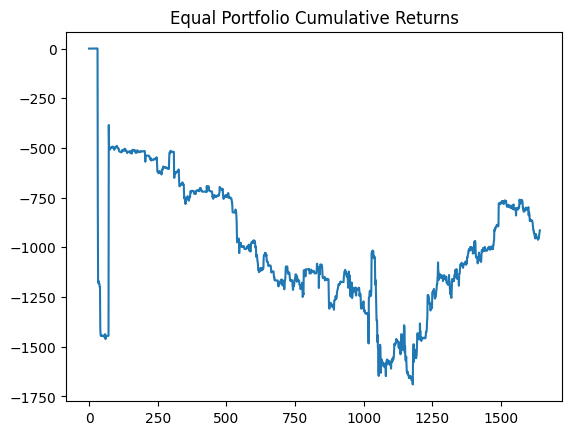

In [388]:
eqports_ff['cum_ret'].plot(title='Equal Portfolio Cumulative Returns')
# eqports_ff['mkt_cum_ret'].plot()

In [270]:
just_dates_df = ff3['date']

In [273]:
strat_port = pd.merge(pd.DataFrame(just_dates_df), eqports, how='left', on='date')

In [279]:
strat_port = strat_port[strat_port['date'] >= 20120726]

In [282]:
strat_port = strat_port.fillna(0)

In [291]:
max(strat_port['RET'])

31.97368500919956

In [284]:
strat_port = pd.merge(strat_port, ff5, how='left', on='date')
strat_port = strat_port.dropna()
strat_port['Mkt-RF'] = pd.to_numeric(strat_port['Mkt-RF'], errors='coerce')
strat_port['SMB'] = pd.to_numeric(strat_port['SMB'], errors='coerce')
strat_port['HML'] = pd.to_numeric(strat_port['HML'], errors='coerce')
strat_port['CMA'] = pd.to_numeric(strat_port['CMA'], errors='coerce')
strat_port['RMW'] = pd.to_numeric(strat_port['RMW'], errors='coerce')

In [285]:
strat_port = pd.merge(strat_port, mom, how='left', on='date')
strat_port['MOM'] = pd.to_numeric(strat_port['MOM'], errors='coerce')

In [307]:
strat_port['cum_ret'] = (1 + (strat_port['RET'] / 100)).cumprod() - 1
strat_port['mkt_cum_ret'] = (1 + (strat_port['Mkt-RF'] / 100)).cumprod() - 1

In [ ]:
copy_portfolio

<Axes: >

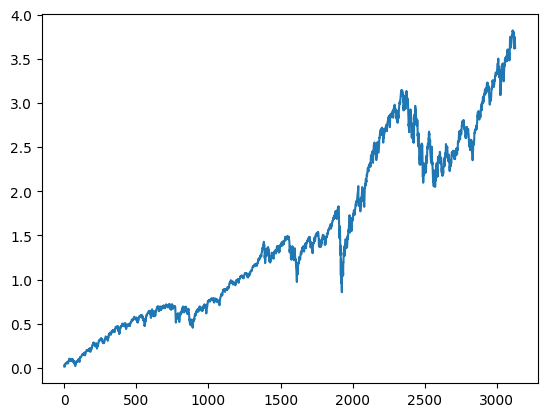

In [346]:
strat_port['mkt_cum_ret'].plot()

<Axes: title={'center': 'Equal Portfolio Cumulative Returns'}>

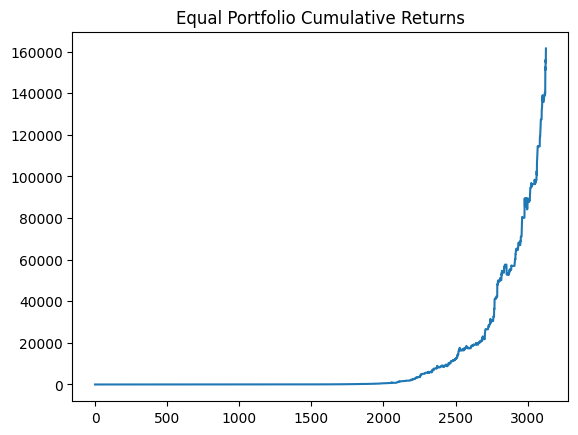

In [308]:
strat_port['cum_ret'].plot(title='Equal Portfolio Cumulative Returns')


<Axes: >

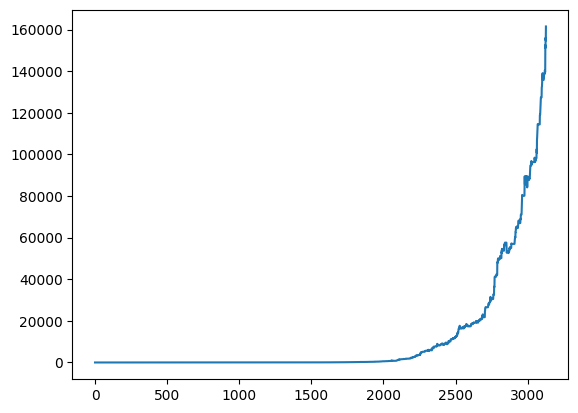

In [304]:
strat_port['cum_ret'].plot()

In [301]:
eqports

,date,RET
0,20120726,0.000000
1,20120727,0.000000
2,20120730,0.000000
3,20120801,0.000000
4,20120802,0.916716
...,...,...
1902,20250516,4.611411
1903,20250519,-0.308990
1904,20250520,2.422843
1905,20250521,-3.601511


In [352]:
strat_port

,date,RET,Mkt-RF,SMB,HML,RMW,CMA,RF,MOM,cum_ret,mkt_cum_ret
0,20120726,0.000000,1.53,-0.80,0.34,0.06,0.27,0.000,-0.64,0.000000,0.015300
1,20120727,0.000000,1.96,0.55,0.07,-0.17,-0.34,0.000,-0.96,0.000000,0.035200
2,20120730,0.000000,-0.13,-0.40,0.23,0.22,0.32,0.000,0.05,0.000000,0.033854
3,20120731,0.000000,-0.47,0.00,0.20,0.47,0.01,0.000,-0.14,0.000000,0.028995
4,20120801,0.000000,-0.50,-1.55,0.36,0.05,0.18,0.000,0.00,0.000000,0.023850
...,...,...,...,...,...,...,...,...,...,...,...
3123,20241224,9.295439,1.11,-0.12,-0.05,-0.13,-0.37,0.017,0.67,152596.960907,3.748640
3124,20241226,-0.920903,0.02,1.09,-0.19,-0.44,0.35,0.017,0.01,151191.682096,3.749589
3125,20241227,3.247195,-1.17,-0.44,0.56,0.41,0.03,0.017,-0.88,156101.203599,3.694019
3126,20241230,-0.889756,-1.09,0.24,0.74,0.55,0.14,0.017,0.06,154712.275158,3.642854


In [ ]:
for idx in events['Index'].unique():
    others = events[events['Index'] == idx].reset_index()
    others = others.drop(['index', 'level_0'], axis=1)

    portfolio = pd.DataFrame()
    no_data = []
    for row in others.iterrows():
        tckr = row[1]['Ticker']
        start_date = row[1]['Announced Date']
        end_date = row[1]['date']
        returns_within_range = get_return(tckr, start_date, end_date)
        if returns_within_range.empty:
            no_data.append({'Ticker': tckr,
                            'Action': row[1]['Action'],
                            'Company': row[1]['Company']})
        returns_within_range['Action'] = row[1]['Action']
        portfolio = pd.concat([portfolio, returns_within_range], ignore_index=True)
    portfolio['LS'] = portfolio['Action'].apply(lambda x : 1 if x == 'Add' else -1 )
    portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)
    portfolio['portfolio_ret'] = portfolio['weight'] * portfolio['RET']

    eqports = portfolio.groupby(['date'])['portfolio_ret'].sum()
    eqports = eqports.dropna(axis=0)
    eqports = eqports * 100
    eqports = eqports.reset_index()

    print(f'{idx} ratio: {eqports[eqports['portfolio_ret'] == 0].count() / len(eqports)}')

    stratmean = eqports['portfolio_ret'].mean()
    stratvol = eqports['portfolio_ret'].std()
    stratsharpe = stratmean/stratvol
    print("{} has mean {}, vol {}, and Sharpe {}".format('Equal Portfolio', stratmean, stratvol, stratsharpe))
    print(divider)
    eqports_ff = pd.merge(eqports, ff6, how='left', on='date')
    eqports_ff = eqports_ff.dropna()
    eqports_ff['Mkt-RF'] = pd.to_numeric(eqports_ff['Mkt-RF'], errors='coerce')
    eqports_ff['SMB'] = pd.to_numeric(eqports_ff['SMB'], errors='coerce')
    eqports_ff['HML'] = pd.to_numeric(eqports_ff['HML'], errors='coerce')
    eqports_ff['RMW'] = pd.to_numeric(eqports_ff['RMW'], errors='coerce')
    eqports_ff['CMA'] = pd.to_numeric(eqports_ff['CMA'], errors='coerce')
    eqports_ff['MOM'] = pd.to_numeric(eqports_ff['MOM'], errors='coerce')
    eqports_ff['RF'] = pd.to_numeric(eqports_ff['RF'], errors='coerce')

    capm_eq=sm.OLS(eqports_ff['portfolio_ret'],
                sm.add_constant(eqports_ff[['Mkt-RF']])).fit()
    print(f'{idx} CAPM')
    print(capm_eq.summary())
    ff3_eq=sm.OLS(eqports_ff['portfolio_ret'],
                sm.add_constant(eqports_ff[['Mkt-RF', 'SMB', 'HML']])).fit()
    print(divider)

    print(f'{idx} FF3')
    print(ff3_eq.summary())
    ff5_eq=sm.OLS(eqports_ff['portfolio_ret'],
                sm.add_constant(eqports_ff[['Mkt-RF', 'SMB', 'HML', 'CMA', 'RMW']])).fit()
    print(ff5_eq.summary())
    print(divider)

    print(f'{idx} FF5')
    ff6_eq=sm.OLS(eqports_ff['portfolio_ret'],
                sm.add_constant(eqports_ff[['Mkt-RF', 'SMB', 'HML', 'CMA', 'RMW', 'MOM']])).fit()
    print(ff6_eq.summary())
    print(divider)
    print(f'{idx} FF6')

    eqports_ff['cum_ret'] = (1 + (eqports_ff['portfolio_ret'] / 100)).cumprod() - 1
    eqports_ff['mkt_cum_ret'] = (1 + (eqports_ff['Mkt-RF'] / 100)).cumprod() - 1
    eqports_ff
    eqports_ff['cum_ret'].plot(title=f'{idx} Equal Portfolio Cumulative Returns')
    eqports_ff['mkt_cum_ret'].plot()
    print(divider)
    print(divider)
    print(divider)